In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from rich.console import Console
from rich.table import Table
from rich.panel import Panel
from rich.text import Text
from rich import box
from rich.theme import Theme
import warnings
warnings.filterwarnings('ignore')

# Set the style and color palette
sns.set_palette("viridis")
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.viridis(np.linspace(0, 1, 20)))

ModuleNotFoundError: No module named 'lightgbm'

In [ ]:
import pickle
import sklearn
print("Pickle module version:", pickle.format_version)
print("Pickle module version:", sklearn.__version__)

Pickle module version: 4.0
Pickle module version: 1.5.1


In [ ]:
df = pd.read_csv(r"D:\Nokia\synthetic_crop_data_tvae.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81000 entries, 0 to 80999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            81000 non-null  int64  
 1   P            81000 non-null  int64  
 2   K            81000 non-null  int64  
 3   temperature  81000 non-null  float64
 4   humidity     81000 non-null  float64
 5   ph           81000 non-null  float64
 6   rainfall     81000 non-null  float64
 7   label        81000 non-null  object 
 8   source       81000 non-null  object 
dtypes: float64(4), int64(3), object(2)
memory usage: 5.6+ MB


In [ ]:
df.head()

N   P   K  temperature   humidity        ph   rainfall      label  \
0  59  70  84    17.519353  18.951751  7.545604  84.222308  Soyabeans   
1  21  79  77    18.541798  15.993441  7.581953  76.948827  Soyabeans   
2  42  74  83    19.184558  14.103879  7.541234  65.547302  Soyabeans   
3  36  78  79    20.044628  14.649560  7.812062  88.837525  Soyabeans   
4  29  71  84    18.707147  19.152620  6.514350  71.613872  Soyabeans   

           source  
0  synthetic_tvae  
1  synthetic_tvae  
2  synthetic_tvae  
3  synthetic_tvae  
4  synthetic_tvae

In [ ]:
print(df.isnull().sum())

N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
source         0
dtype: int64


In [ ]:
df.describe()

N             P             K   temperature      humidity  \
count  81000.000000  81000.000000  81000.000000  81000.000000  81000.000000   
mean      45.711037     54.581074     45.178370     25.443762     66.565533   
std       35.278387     30.335554     47.300489      5.081611     25.093088   
min        0.000000      5.000000      5.000000      8.000000     14.043878   
25%       20.000000     35.000000     20.000000     22.207917     51.295699   
50%       34.000000     55.000000     26.000000     25.575800     76.050000   
75%       75.000000     69.000000     48.000000     28.629940     87.567455   
max      140.000000    145.000000    205.000000     43.000000    100.000000   

                 ph      rainfall  
count  81000.000000  81000.000000  
mean       6.480961     99.152703  
std        0.865274     52.542573  
min        3.500000     20.000000  
25%        5.924780     61.218249  
50%        6.427154     90.785090  
75%        6.966387    120.258135  
max        9.500000    300.000000

In [ ]:
def format_summary_statistics(df):
    """
    Create a professionally formatted summary of statistics by crop for each feature.

    Parameters:
    df (pandas.DataFrame): Input dataframe with crop data

    Returns:
    None: Prints formatted statistics
    """
    # Set pandas display options for better formatting
    pd.set_option('display.float_format', lambda x: '%.2f' % x)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)

    features = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']

    print("\n" + "="*80)
    print("CROP-WISE SUMMARY STATISTICS")
    print("="*80)

    for feature in features:
        # Create summary statistics
        stats_df = df.groupby('label')[feature].describe()

        # Add additional statistics
        stats_df['range'] = stats_df['max'] - stats_df['min']
        stats_df['cv'] = (stats_df['std'] / stats_df['mean']) * 100  # Coefficient of variation

        # Rename columns for better readability
        stats_df = stats_df.rename(columns={
            'count': 'Count',
            'mean': 'Mean',
            'std': 'Std Dev',
            'min': 'Min',
            '25%': '25th Perc',
            '50%': 'Median',
            '75%': '75th Perc',
            'max': 'Max',
            'range': 'Range',
            'cv': 'CV (%)'
        })

        print(f"\n{'-'*80}")
        print(f"Feature: {feature.upper()}")
        print(f"{'-'*80}")

        # Format the DataFrame for display
        styled_df = stats_df.style\
            .format({
                'Count': '{:.0f}',
                'Mean': '{:.2f}',
                'Std Dev': '{:.2f}',
                'Min': '{:.2f}',
                '25th Perc': '{:.2f}',
                'Median': '{:.2f}',
                '75th Perc': '{:.2f}',
                'Max': '{:.2f}',
                'Range': '{:.2f}',
                'CV (%)': '{:.2f}'
            })\
            .background_gradient(cmap='viridis', subset=['Mean', 'Median'])\
            .highlight_max(color='lightgreen', subset=['Max'])\
            .highlight_min(color='lightsalmon', subset=['Min'])

        display(styled_df)

        # Print feature insights
        print("\nKey Insights:")
        print(f"• Highest {feature} requirement: {stats_df['Max'].idxmax()} crop")
        print(f"• Lowest {feature} requirement: {stats_df['Min'].idxmin()} crop")
        print(f"• Most variable {feature} (highest CV): {stats_df['CV (%)'].idxmax()} crop")
        print(f"• Most consistent {feature} (lowest CV): {stats_df['CV (%)'].idxmin()} crop")

# Execute the function
format_summary_statistics(df)

# Reset display options to default
pd.reset_option('display.float_format')
pd.reset_option('display.max_columns')
pd.reset_option('display.width')
format_summary_statistics(df)


CROP-WISE SUMMARY STATISTICS

--------------------------------------------------------------------------------
Feature: N
--------------------------------------------------------------------------------



Key Insights:
• Highest N requirement: cotton crop
• Lowest N requirement: apple crop
• Most variable N (highest CV): pomegranate crop
• Most consistent N (lowest CV): cotton crop

--------------------------------------------------------------------------------
Feature: P
--------------------------------------------------------------------------------



Key Insights:
• Highest P requirement: apple crop
• Lowest P requirement: coconut crop
• Most variable P (highest CV): coconut crop
• Most consistent P (lowest CV): grapes crop

--------------------------------------------------------------------------------
Feature: K
--------------------------------------------------------------------------------



Key Insights:
• Highest K requirement: apple crop
• Lowest K requirement: orange crop
• Most variable K (highest CV): orange crop
• Most consistent K (lowest CV): grapes crop

--------------------------------------------------------------------------------
Feature: TEMPERATURE
--------------------------------------------------------------------------------



Key Insights:
• Highest temperature requirement: papaya crop
• Lowest temperature requirement: grapes crop
• Most variable temperature (highest CV): grapes crop
• Most consistent temperature (lowest CV): cowpeas crop

--------------------------------------------------------------------------------
Feature: HUMIDITY
--------------------------------------------------------------------------------



Key Insights:
• Highest humidity requirement: coconut crop
• Lowest humidity requirement: Soyabeans crop
• Most variable humidity (highest CV): peas crop
• Most consistent humidity (lowest CV): grapes crop

--------------------------------------------------------------------------------
Feature: PH
--------------------------------------------------------------------------------



Key Insights:
• Highest ph requirement: groundnuts crop
• Lowest ph requirement: groundnuts crop
• Most variable ph (highest CV): mothbeans crop
• Most consistent ph (lowest CV): papaya crop

--------------------------------------------------------------------------------
Feature: RAINFALL
--------------------------------------------------------------------------------



Key Insights:
• Highest rainfall requirement: rice crop
• Lowest rainfall requirement: rice crop
• Most variable rainfall (highest CV): papaya crop
• Most consistent rainfall (lowest CV): pomegranate crop

CROP-WISE SUMMARY STATISTICS

--------------------------------------------------------------------------------
Feature: N
--------------------------------------------------------------------------------



Key Insights:
• Highest N requirement: cotton crop
• Lowest N requirement: apple crop
• Most variable N (highest CV): pomegranate crop
• Most consistent N (lowest CV): cotton crop

--------------------------------------------------------------------------------
Feature: P
--------------------------------------------------------------------------------



Key Insights:
• Highest P requirement: apple crop
• Lowest P requirement: coconut crop
• Most variable P (highest CV): coconut crop
• Most consistent P (lowest CV): grapes crop

--------------------------------------------------------------------------------
Feature: K
--------------------------------------------------------------------------------



Key Insights:
• Highest K requirement: apple crop
• Lowest K requirement: orange crop
• Most variable K (highest CV): orange crop
• Most consistent K (lowest CV): grapes crop

--------------------------------------------------------------------------------
Feature: TEMPERATURE
--------------------------------------------------------------------------------



Key Insights:
• Highest temperature requirement: papaya crop
• Lowest temperature requirement: grapes crop
• Most variable temperature (highest CV): grapes crop
• Most consistent temperature (lowest CV): cowpeas crop

--------------------------------------------------------------------------------
Feature: HUMIDITY
--------------------------------------------------------------------------------



Key Insights:
• Highest humidity requirement: coconut crop
• Lowest humidity requirement: Soyabeans crop
• Most variable humidity (highest CV): peas crop
• Most consistent humidity (lowest CV): grapes crop

--------------------------------------------------------------------------------
Feature: PH
--------------------------------------------------------------------------------



Key Insights:
• Highest ph requirement: groundnuts crop
• Lowest ph requirement: groundnuts crop
• Most variable ph (highest CV): mothbeans crop
• Most consistent ph (lowest CV): papaya crop

--------------------------------------------------------------------------------
Feature: RAINFALL
--------------------------------------------------------------------------------



Key Insights:
• Highest rainfall requirement: rice crop
• Lowest rainfall requirement: rice crop
• Most variable rainfall (highest CV): papaya crop
• Most consistent rainfall (lowest CV): pomegranate crop


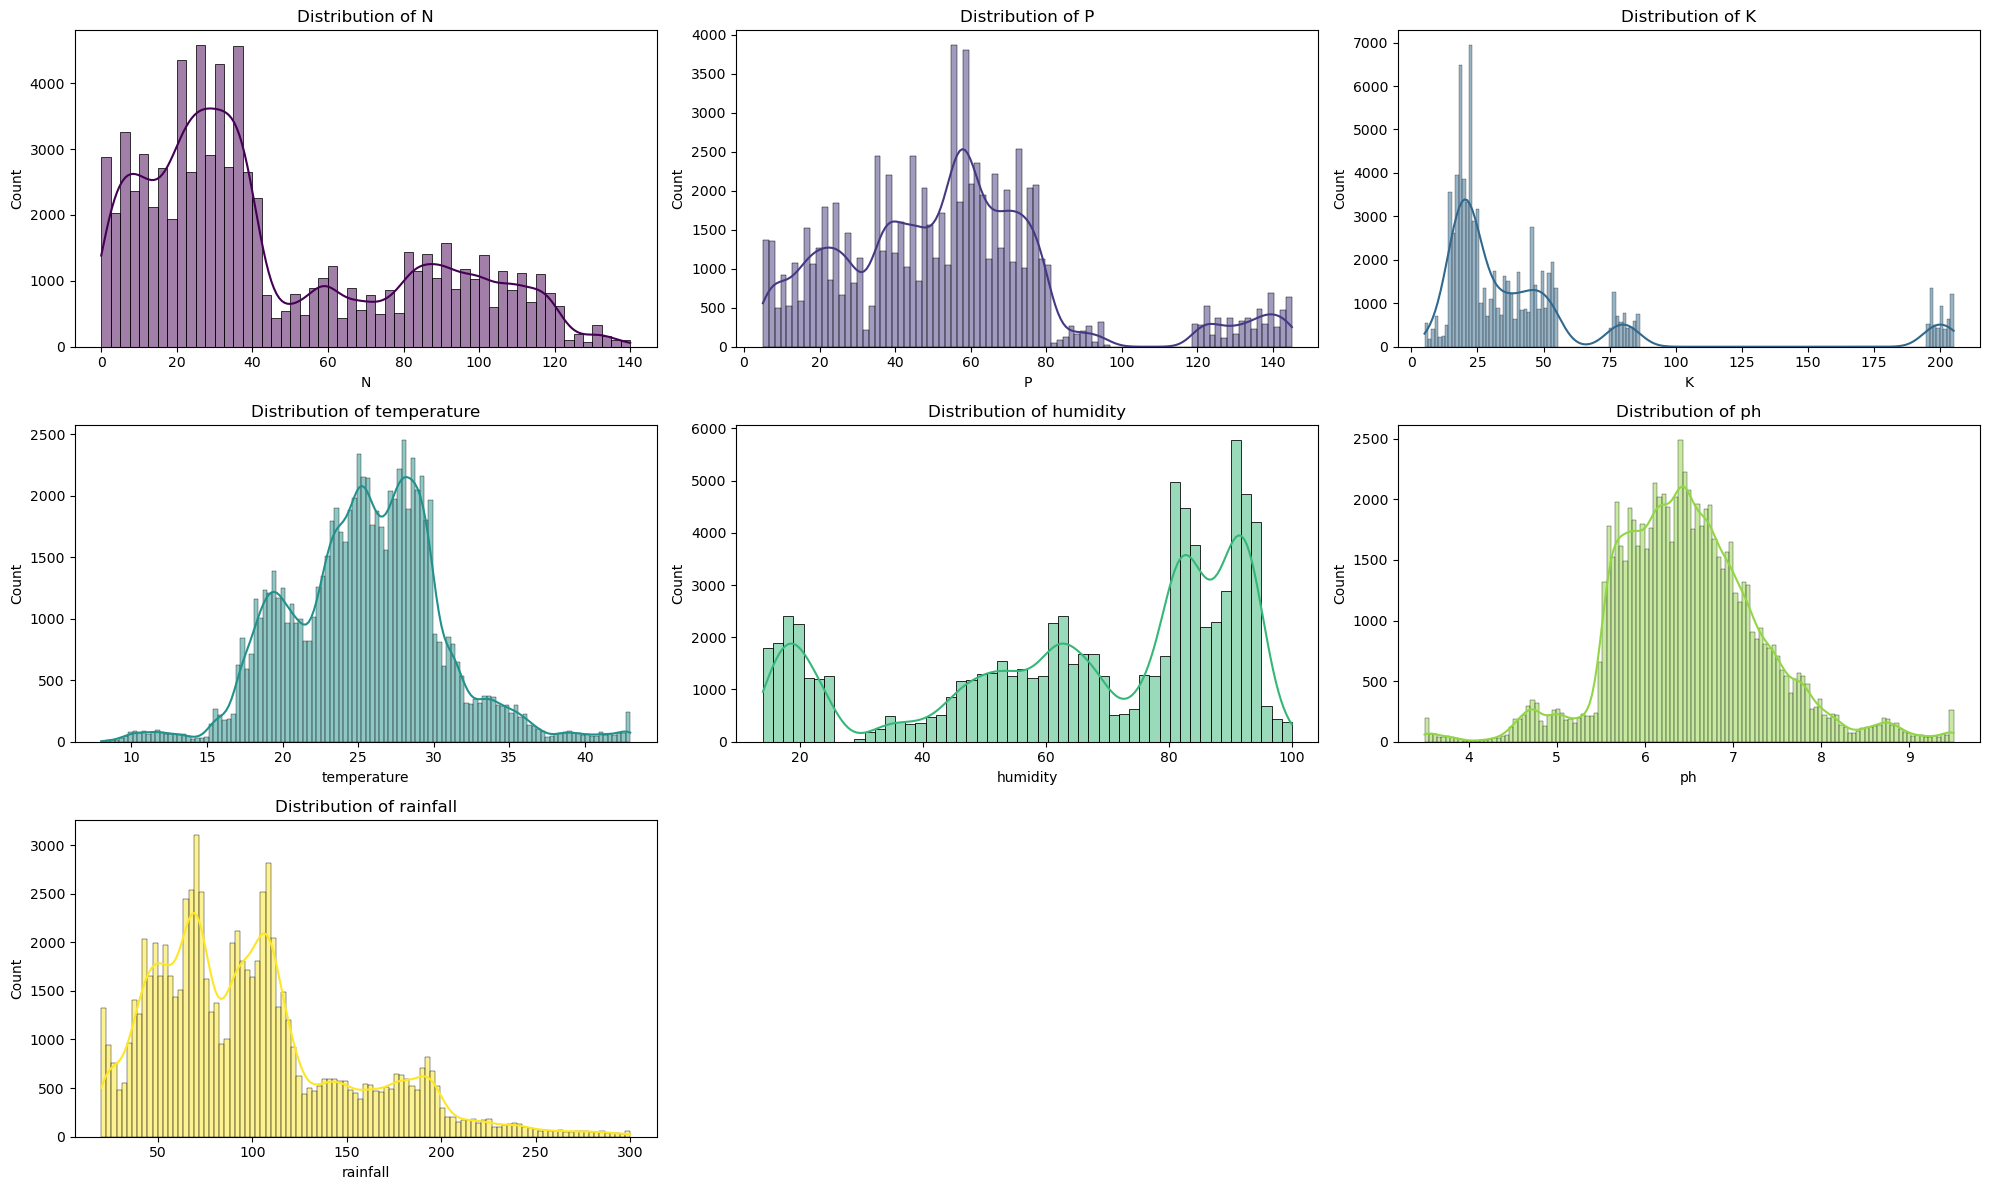

In [ ]:
plt.figure(figsize=(20, 12))
colors = plt.cm.viridis(np.linspace(0, 1, 7))

for i, (column, color) in enumerate(zip(['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall'], colors)):
    plt.subplot(3, 3, i+1)
    sns.histplot(data=df, x=column, kde=True, color=color)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()


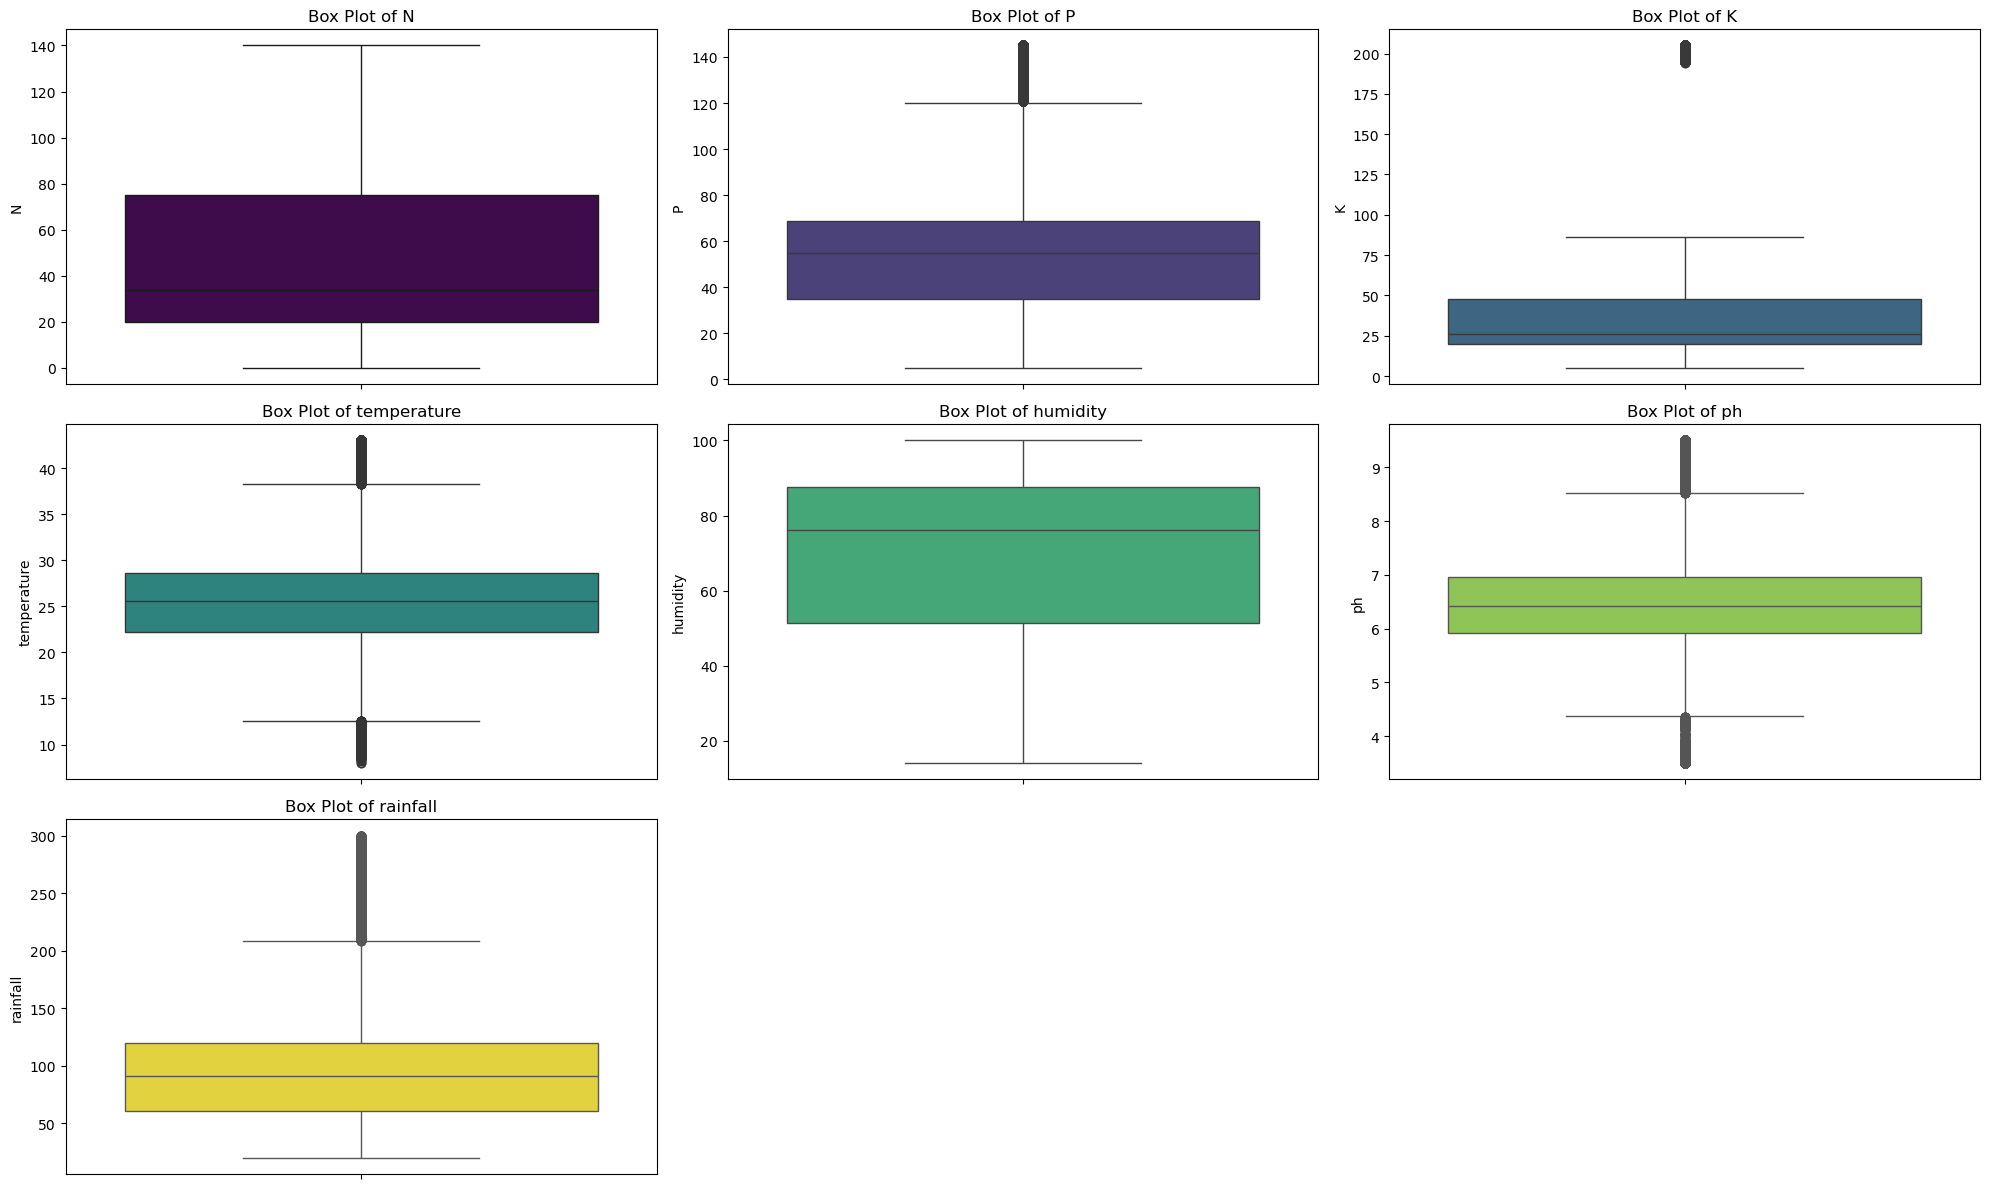

In [ ]:
plt.figure(figsize=(20, 12))
for i, (column, color) in enumerate(zip(['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall'], colors)):
    plt.subplot(3, 3, i+1)
    sns.boxplot(data=df, y=column, color=color)
    plt.title(f'Box Plot of {column}')
plt.tight_layout()
plt.show()

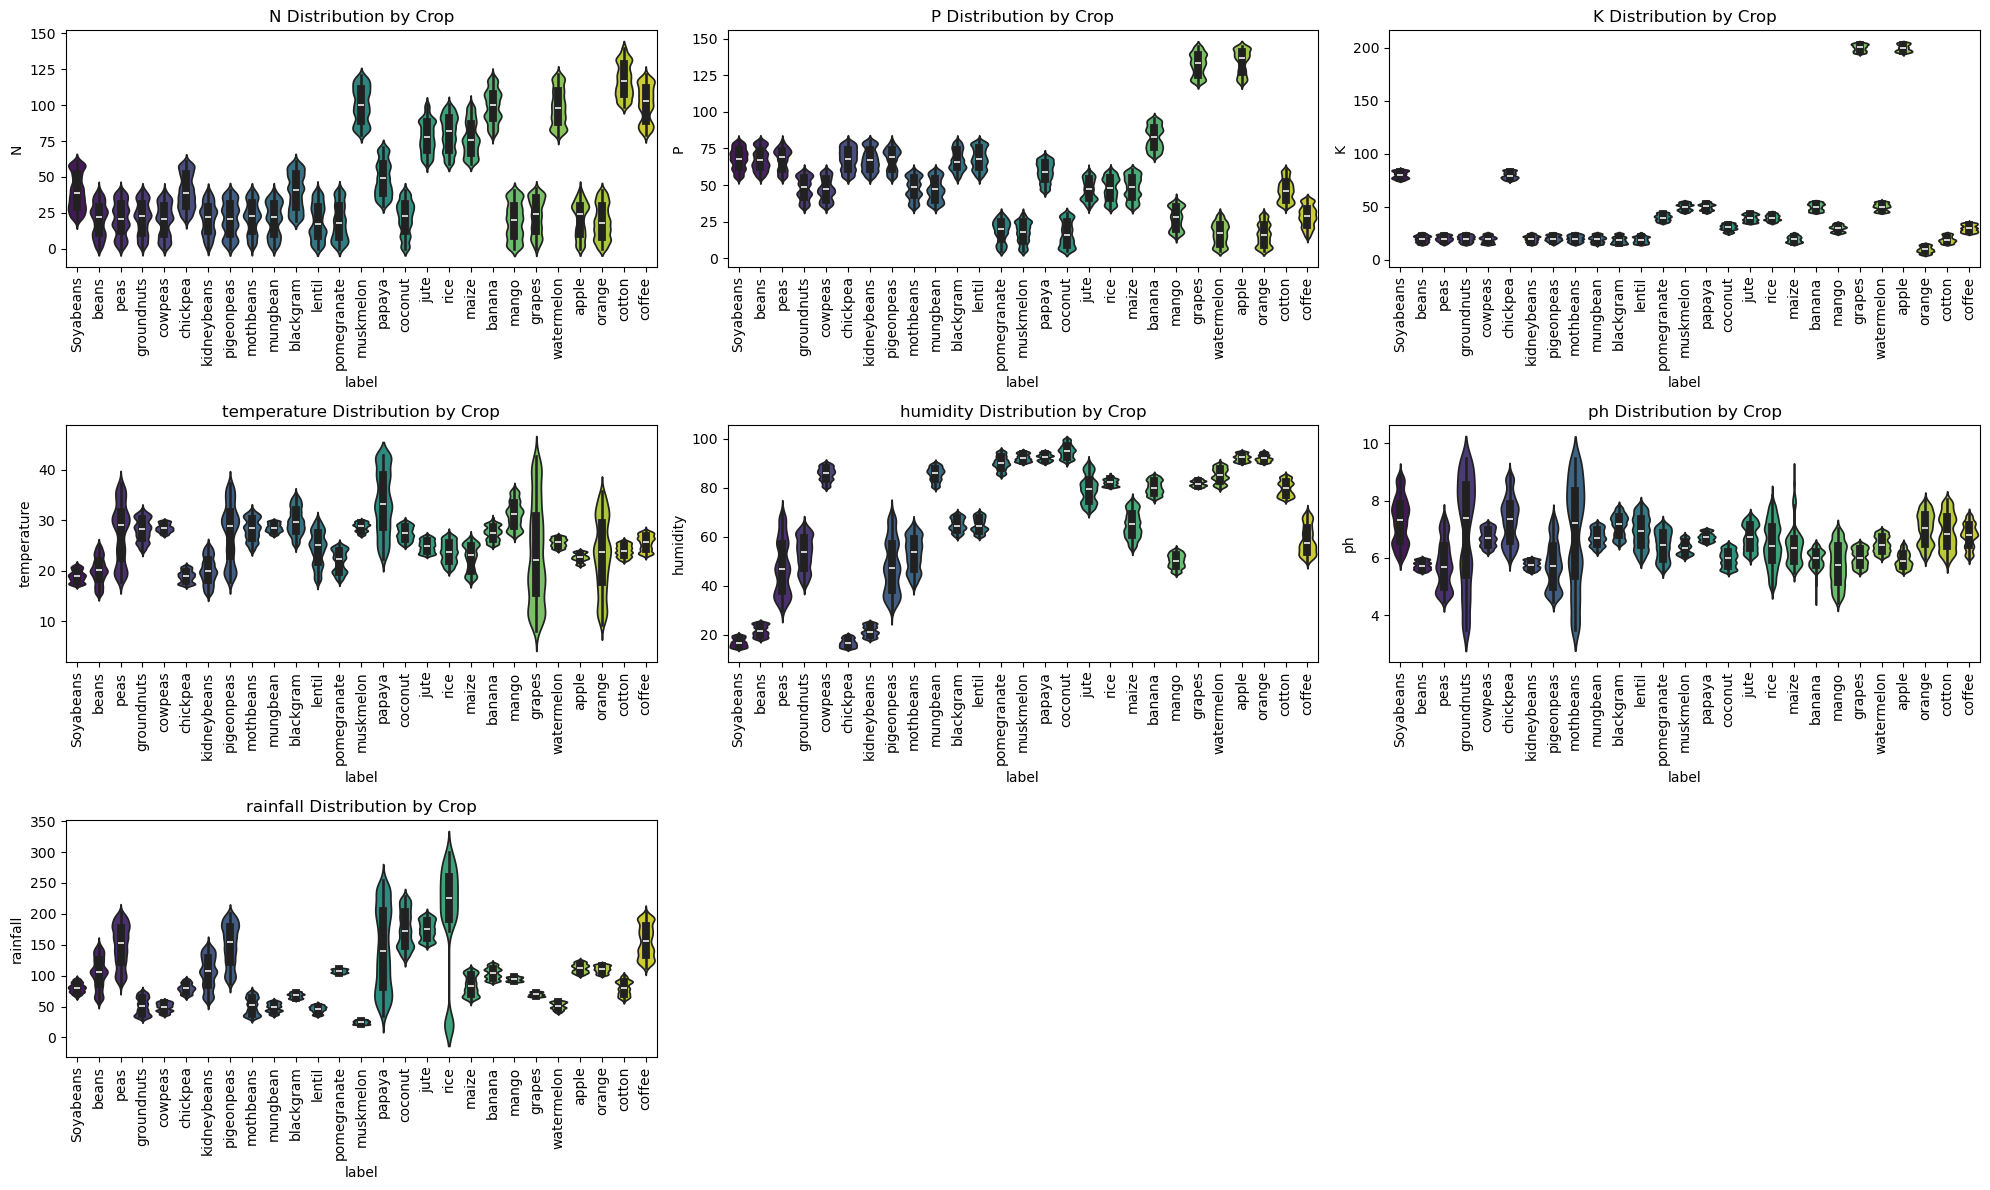

In [ ]:
plt.figure(figsize=(20, 12))
for i, column in enumerate(['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']):
    plt.subplot(3, 3, i+1)
    sns.violinplot(data=df, x='label', y=column, palette='viridis')
    plt.xticks(rotation=90)
    plt.title(f'{column} Distribution by Crop')
plt.tight_layout()
plt.show()

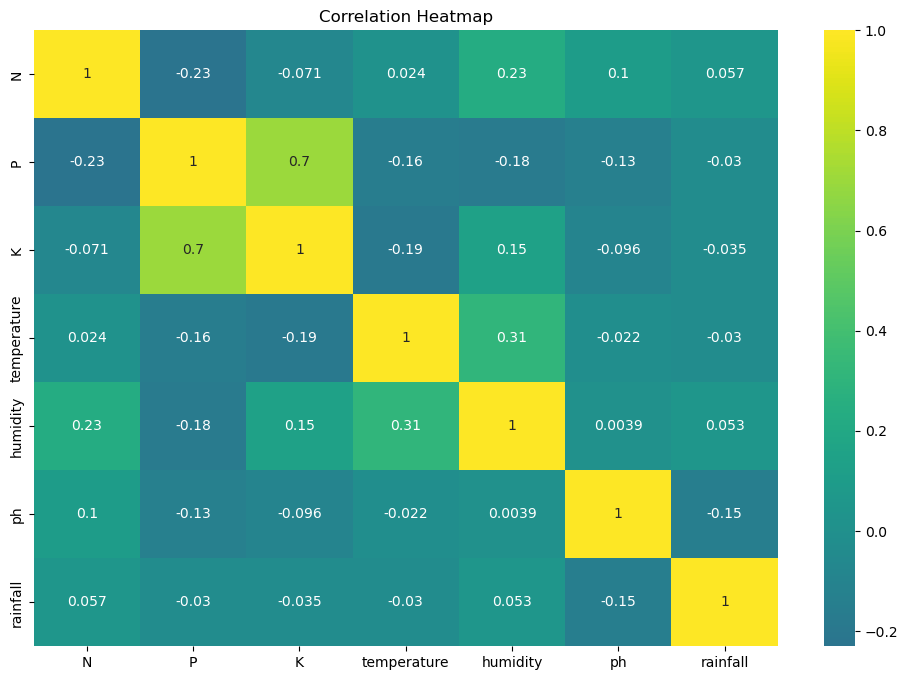

In [ ]:
plt.figure(figsize=(12, 8))

# Drop non-numeric columns
correlation_matrix = df.drop(['label', 'source'], axis=1).corr()

sns.heatmap(correlation_matrix, annot=True, cmap='viridis', center=0)
plt.title('Correlation Heatmap')
plt.show()


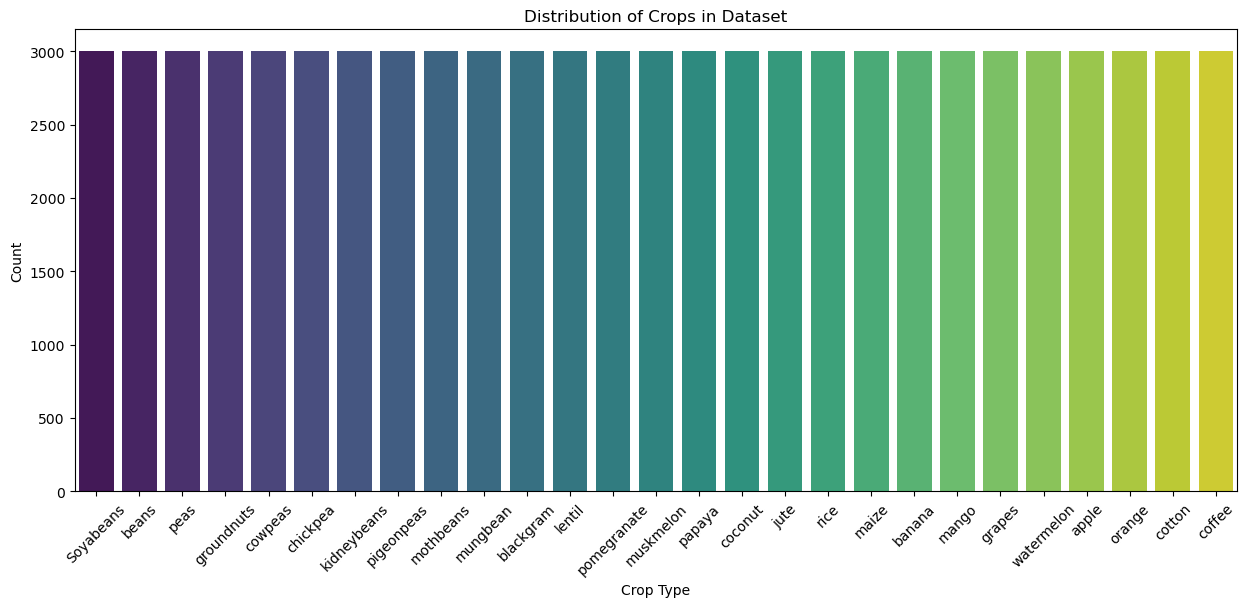

In [ ]:
plt.figure(figsize=(15, 6))
sns.countplot(data=df, x='label', palette='viridis')
plt.xticks(rotation=45)
plt.title('Distribution of Crops in Dataset')
plt.xlabel('Crop Type')
plt.ylabel('Count')
plt.show()


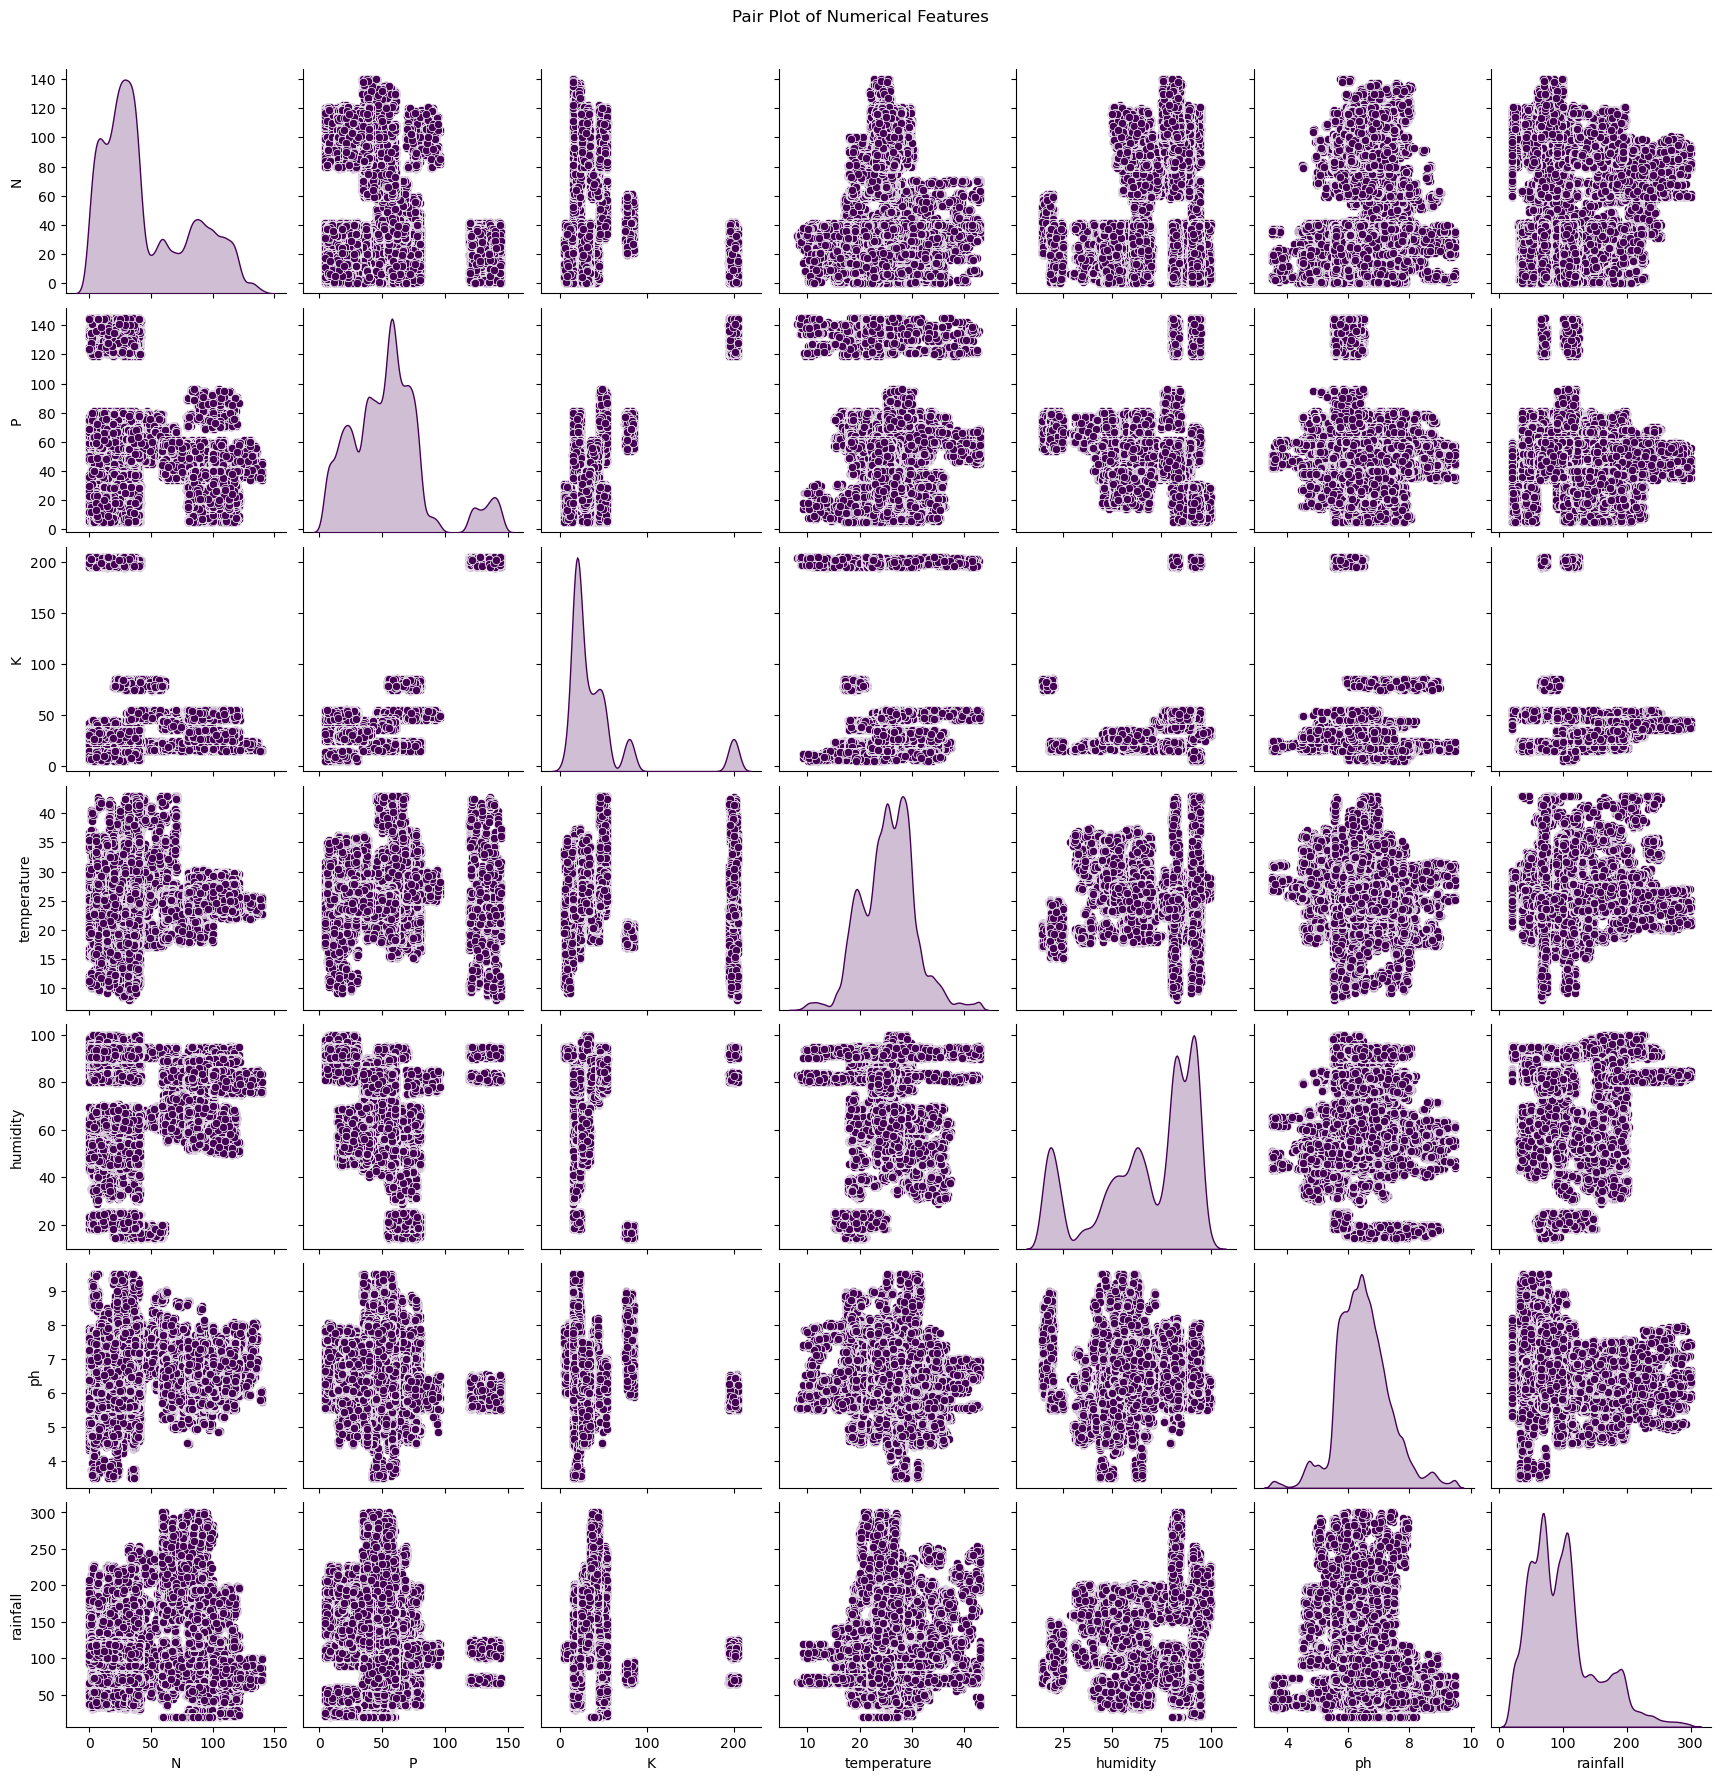

In [ ]:
sns.pairplot(df.drop('label', axis=1), diag_kind='kde', palette='viridis')
plt.suptitle('Pair Plot of Numerical Features', y=1.02)
plt.show()

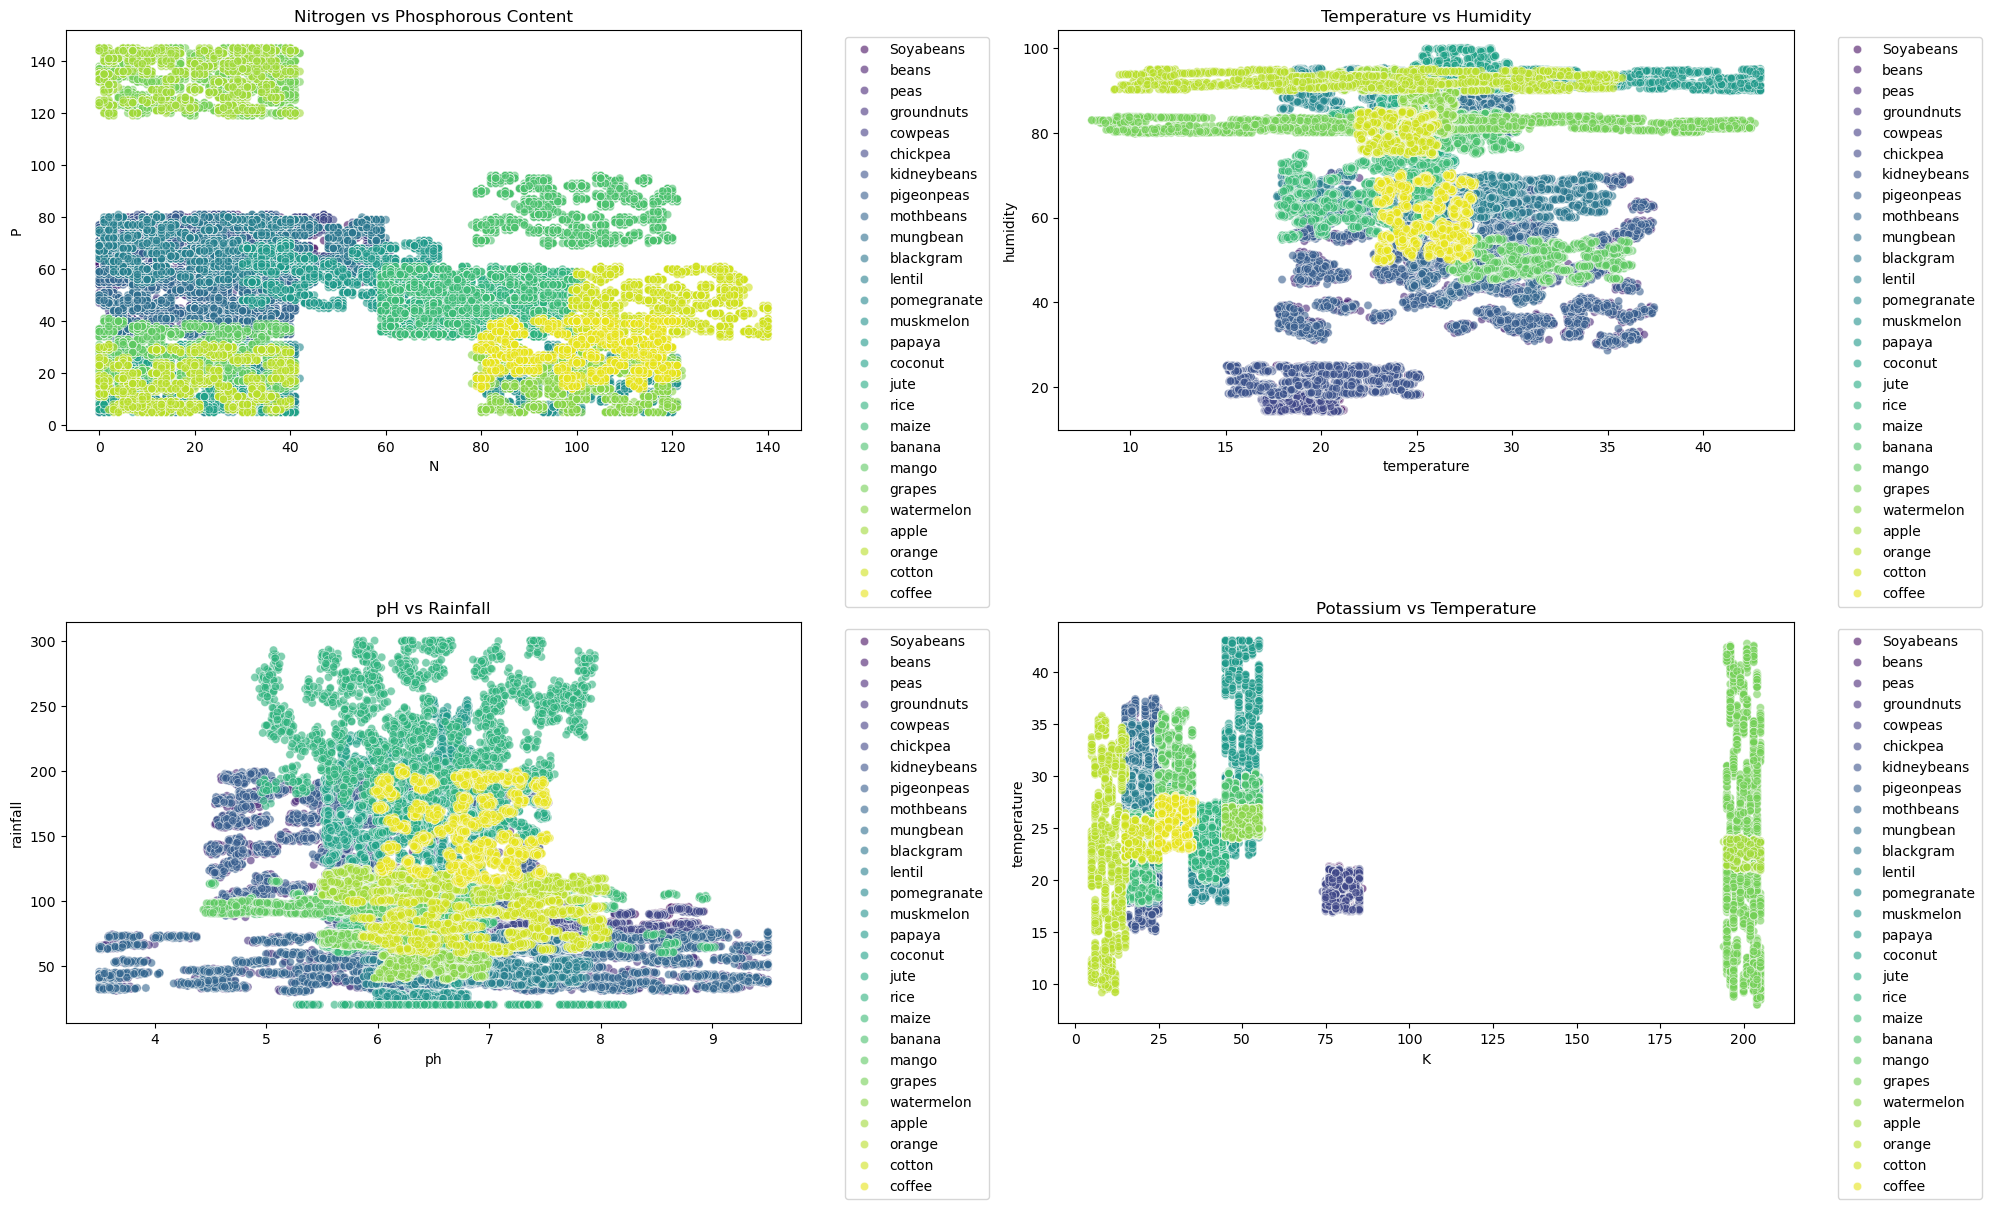

In [ ]:

plt.figure(figsize=(20, 12))

# N vs P
plt.subplot(2, 2, 1)
sns.scatterplot(data=df, x='N', y='P', hue='label', palette='viridis', alpha=0.6)
plt.title('Nitrogen vs Phosphorous Content')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Temperature vs Humidity
plt.subplot(2, 2, 2)
sns.scatterplot(data=df, x='temperature', y='humidity', hue='label', palette='viridis', alpha=0.6)
plt.title('Temperature vs Humidity')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# pH vs Rainfall
plt.subplot(2, 2, 3)
sns.scatterplot(data=df, x='ph', y='rainfall', hue='label', palette='viridis', alpha=0.6)
plt.title('pH vs Rainfall')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# K vs Temperature
plt.subplot(2, 2, 4)
sns.scatterplot(data=df, x='K', y='temperature', hue='label', palette='viridis', alpha=0.6)
plt.title('Potassium vs Temperature')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:

print("Skewness Analysis:")
print("=================")
numerical_features = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
for feature in numerical_features:
    skewness = df[feature].skew()
    print(f"{feature}: {skewness:.3f}")


Skewness Analysis:
N: 0.753
P: 0.959
K: 2.541
temperature: 0.137
humidity: -0.764
ph: 0.292
rainfall: 0.988


In [ ]:

def print_feature_ranges(df, numerical_features):
    """
    Print beautifully formatted feature ranges with dark mode optimized colors.

    Parameters:
    df (pandas.DataFrame): Input dataframe with crop data
    numerical_features (list): List of numerical feature names
    """
    # Custom theme for dark mode
    custom_theme = Theme({
        "info": "bright_yellow",
        "title": "bright_white on blue",
        "crop": "bright_green",
        "feature": "bright_cyan",
        "header": "bright_magenta",
        "border": "bright_blue",
        "stats": "bright_yellow",
        "highlight": "bright_white",
        "value": "bright_green"
    })

    console = Console(theme=custom_theme)
    data_rows = []

    # Create title
    title = Text("🌾 FEATURE RANGES BY CROP 🌾", style="title")
    title_panel = Panel(
        title,
        box=box.DOUBLE,
        padding=(1, 30),
        style="border",
        title="Analysis Report"
    )
    console.print("\n")
    console.print(title_panel)
    console.print("\n")

    # Process each crop
    for crop in sorted(df['label'].unique()):
        crop_data = df[df['label'] == crop]

        # Create crop header
        crop_title = Text(f"\n📊 Crop: {crop.upper()}", style="crop")
        console.print(crop_title)

        # Create table for this crop
        table = Table(
            show_header=True,
            header_style="header",
            box=box.ROUNDED,
            border_style="border",
            show_lines=True,
            title=f"Statistics for {crop.upper()}",
            title_style="highlight"
        )

        # Add columns
        table.add_column("Feature", style="feature", justify="left")
        table.add_column("Minimum", style="value", justify="right")
        table.add_column("Maximum", style="value", justify="right")
        table.add_column("Range", style="value", justify="right")
        table.add_column("Mean", style="value", justify="right")

        # Process features for this crop
        for feature in numerical_features:
            min_val = crop_data[feature].min()
            max_val = crop_data[feature].max()
            mean_val = crop_data[feature].mean()
            range_val = max_val - min_val

            # Add row to table
            table.add_row(
                feature,
                f"{min_val:,.2f}",
                f"{max_val:,.2f}",
                f"{range_val:,.2f}",
                f"{mean_val:,.2f}"
            )

            # Store data for DataFrame
            data_rows.append({
                'Crop': crop,
                'Feature': feature,
                'Min': min_val,
                'Max': max_val,
                'Range': range_val,
                'Mean': mean_val
            })

        # Print table with border
        console.print(Panel(table, border_style="border"))

        # Print summary statistics for this crop
        summary_text = Text("\n📈 Key Statistics:", style="stats")
        console.print(summary_text)

        # Find feature with highest range
        max_range_feature = max(numerical_features, key=lambda x: crop_data[x].max() - crop_data[x].min())
        max_range_value = crop_data[max_range_feature].max() - crop_data[max_range_feature].min()

        # Find feature with highest variability (coefficient of variation)
        cv_values = {feature: crop_data[feature].std() / crop_data[feature].mean() * 100
                    for feature in numerical_features}
        most_variable_feature = max(cv_values, key=cv_values.get)

        # Print statistics with improved formatting
        console.print(Panel(
            "\n".join([
                f"[highlight]•[/highlight] Most variable feature: [feature]{max_range_feature}[/feature] (Range: [value]{max_range_value:,.2f}[/value])",
                f"[highlight]•[/highlight] Highest CV: [feature]{most_variable_feature}[/feature] (CV: [value]{cv_values[most_variable_feature]:.2f}%[/value])",
                f"[highlight]•[/highlight] Average {max_range_feature}: [value]{crop_data[max_range_feature].mean():,.2f}[/value]"
            ]),
            title="Summary",
            border_style="border",
            box=box.ROUNDED
        ))

        console.print("\n" + "─" * 80 + "\n")

    return pd.DataFrame(data_rows)

# Execute the function
feature_ranges_df = print_feature_ranges(df, numerical_features)

╔════════════════════════════════════════════════ Analysis Report ════════════════════════════════════════════════╗
║                                                                                                                 ║
║                              🌾 FEATURE RANGES BY CROP 🌾                                                       ║
║                                                                                                                 ║
╚═════════════════════════════════════════════════════════════════════════════════════════════════════════════════╝

📊 Crop: SOYABEANS

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│              Statistics for SOYABEANS                                                                           │
│ ╭─────────────┬─────────┬─────────┬───────┬───────╮                                                             │
│ │ Feature     │ Minimum │ Maximum │ Range │  Mean │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ N           │   19.00 │   61.00 │ 42.00 │ 39.80 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ P           │   54.00 │   81.00 │ 27.00 │ 68.06 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ K           │   75.00 │   86.00 │ 11.00 │ 80.24 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ temperature │   16.93 │   21.35 │  4.42 │ 18.93 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ humidity    │   14.04 │   20.30 │  6.26 │ 16.93 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ ph          │    5.91 │    8.97 │  3.05 │  7.31 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ rainfall    │   64.35 │   96.85 │ 32.51 │ 80.49 │                                                             │
│ ╰─────────────┴─────────┴─────────┴───────┴───────╯                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

📈 Key Statistics:

╭──────────────────────────────────────────────────── Summary ────────────────────────────────────────────────────╮
│ • Most variable feature: N (Range: 42.00)                                                                       │
│ • Highest CV: N (CV: 31.48%)                                                                                    │
│ • Average N: 39.80                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

────────────────────────────────────────────────────────────────────────────────

📊 Crop: APPLE

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│                 Statistics for APPLE                                                                            │
│ ╭─────────────┬─────────┬─────────┬───────┬────────╮                                                            │
│ │ Feature     │ Minimum │ Maximum │ Range │   Mean │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ N           │    0.00 │   42.00 │ 42.00 │  20.77 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ P           │  119.00 │  145.00 │ 26.00 │ 134.35 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ K           │  194.00 │  205.00 │ 11.00 │ 199.90 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ temperature │   20.93 │   24.08 │  3.16 │  22.64 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ humidity    │   89.87 │   95.15 │  5.28 │  92.37 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ ph          │    5.49 │    6.52 │  1.04 │   5.93 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ rainfall    │   99.62 │  125.75 │ 26.13 │ 112.49 │                                                            │
│ ╰─────────────┴─────────┴─────────┴───────┴────────╯                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

📈 Key Statistics:

╭──────────────────────────────────────────────────── Summary ────────────────────────────────────────────────────╮
│ • Most variable feature: N (Range: 42.00)                                                                       │
│ • Highest CV: N (CV: 57.35%)                                                                                    │
│ • Average N: 20.77                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

────────────────────────────────────────────────────────────────────────────────

📊 Crop: BANANA

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│                Statistics for BANANA                                                                            │
│ ╭─────────────┬─────────┬─────────┬───────┬────────╮                                                            │
│ │ Feature     │ Minimum │ Maximum │ Range │   Mean │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ N           │   78.00 │  121.00 │ 43.00 │  99.61 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ P           │   69.00 │   96.00 │ 27.00 │  82.68 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ K           │   45.00 │   55.00 │ 10.00 │  50.08 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ temperature │   24.86 │   30.43 │  5.57 │  27.44 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ humidity    │   74.77 │   85.33 │ 10.56 │  80.20 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ ph          │    4.49 │    6.51 │  2.02 │   5.96 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ rainfall    │   89.12 │  120.96 │ 31.84 │ 104.14 │                                                            │
│ ╰─────────────┴─────────┴─────────┴───────┴────────╯                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

📈 Key Statistics:

╭──────────────────────────────────────────────────── Summary ────────────────────────────────────────────────────╮
│ • Most variable feature: N (Range: 43.00)                                                                       │
│ • Highest CV: N (CV: 11.29%)                                                                                    │
│ • Average N: 99.61                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

────────────────────────────────────────────────────────────────────────────────

📊 Crop: BEANS

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│                 Statistics for BEANS                                                                            │
│ ╭─────────────┬─────────┬─────────┬───────┬────────╮                                                            │
│ │ Feature     │ Minimum │ Maximum │ Range │   Mean │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ N           │    0.00 │   42.00 │ 42.00 │  20.60 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ P           │   54.00 │   81.00 │ 27.00 │  67.66 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ K           │   15.00 │   25.00 │ 10.00 │  20.09 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ temperature │   15.13 │   25.18 │ 10.05 │  20.08 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ humidity    │   17.79 │   25.22 │  7.43 │  21.63 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ ph          │    5.49 │    6.01 │  0.52 │   5.74 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ rainfall    │   57.39 │  151.51 │ 94.12 │ 104.90 │                                                            │
│ ╰─────────────┴─────────┴─────────┴───────┴────────╯                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

📈 Key Statistics:

╭──────────────────────────────────────────────────── Summary ────────────────────────────────────────────────────╮
│ • Most variable feature: rainfall (Range: 94.12)                                                                │
│ • Highest CV: N (CV: 55.02%)                                                                                    │
│ • Average rainfall: 104.90                                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

────────────────────────────────────────────────────────────────────────────────

📊 Crop: BLACKGRAM

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│              Statistics for BLACKGRAM                                                                           │
│ ╭─────────────┬─────────┬─────────┬───────┬───────╮                                                             │
│ │ Feature     │ Minimum │ Maximum │ Range │  Mean │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ N           │   19.00 │   61.00 │ 42.00 │ 40.18 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ P           │   54.00 │   81.00 │ 27.00 │ 67.20 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ K           │   15.00 │   25.00 │ 10.00 │ 19.26 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ temperature │   24.79 │   35.25 │ 10.46 │ 29.91 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ humidity    │   59.64 │   70.17 │ 10.53 │ 64.95 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ ph          │    6.45 │    7.80 │  1.36 │  7.14 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ rainfall    │   59.95 │   75.46 │ 15.51 │ 67.92 │                                                             │
│ ╰─────────────┴─────────┴─────────┴───────┴───────╯                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

📈 Key Statistics:

╭──────────────────────────────────────────────────── Summary ────────────────────────────────────────────────────╮
│ • Most variable feature: N (Range: 42.00)                                                                       │
│ • Highest CV: N (CV: 31.33%)                                                                                    │
│ • Average N: 40.18                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

────────────────────────────────────────────────────────────────────────────────

📊 Crop: CHICKPEA

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│               Statistics for CHICKPEA                                                                           │
│ ╭─────────────┬─────────┬─────────┬───────┬───────╮                                                             │
│ │ Feature     │ Minimum │ Maximum │ Range │  Mean │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ N           │   19.00 │   61.00 │ 42.00 │ 40.26 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ P           │   54.00 │   81.00 │ 27.00 │ 67.93 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ K           │   74.00 │   85.00 │ 11.00 │ 79.92 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ temperature │   16.87 │   21.09 │  4.22 │ 18.89 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ humidity    │   14.09 │   20.10 │  6.01 │ 16.84 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ ph          │    5.88 │    8.98 │  3.10 │  7.33 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ rainfall    │   64.15 │   95.96 │ 31.82 │ 79.86 │                                                             │
│ ╰─────────────┴─────────┴─────────┴───────┴───────╯                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

📈 Key Statistics:

╭──────────────────────────────────────────────────── Summary ────────────────────────────────────────────────────╮
│ • Most variable feature: N (Range: 42.00)                                                                       │
│ • Highest CV: N (CV: 29.55%)                                                                                    │
│ • Average N: 40.26                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

────────────────────────────────────────────────────────────────────────────────

📊 Crop: COCONUT

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│                Statistics for COCONUT                                                                           │
│ ╭─────────────┬─────────┬─────────┬────────┬────────╮                                                           │
│ │ Feature     │ Minimum │ Maximum │  Range │   Mean │                                                           │
│ ├─────────────┼─────────┼─────────┼────────┼────────┤                                                           │
│ │ N           │    0.00 │   41.00 │  41.00 │  21.68 │                                                           │
│ ├─────────────┼─────────┼─────────┼────────┼────────┤                                                           │
│ │ P           │    5.00 │   31.00 │  26.00 │  16.97 │                                                           │
│ ├─────────────┼─────────┼─────────┼────────┼────────┤                                                           │
│ │ K           │   25.00 │   35.00 │  10.00 │  30.64 │                                                           │
│ ├─────────────┼─────────┼─────────┼────────┼────────┤                                                           │
│ │ temperature │   24.85 │   30.02 │   5.18 │  27.42 │                                                           │
│ ├─────────────┼─────────┼─────────┼────────┼────────┤                                                           │
│ │ humidity    │   89.79 │  100.00 │  10.21 │  94.87 │                                                           │
│ ├─────────────┼─────────┼─────────┼────────┼────────┤                                                           │
│ │ ph          │    5.48 │    6.49 │   1.02 │   5.98 │                                                           │
│ ├─────────────┼─────────┼─────────┼────────┼────────┤                                                           │
│ │ rainfall    │  126.86 │  228.28 │ 101.42 │ 176.09 │                                                           │
│ ╰─────────────┴─────────┴─────────┴────────┴────────╯                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

📈 Key Statistics:

╭──────────────────────────────────────────────────── Summary ────────────────────────────────────────────────────╮
│ • Most variable feature: rainfall (Range: 101.42)                                                               │
│ • Highest CV: N (CV: 53.50%)                                                                                    │
│ • Average rainfall: 176.09                                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

────────────────────────────────────────────────────────────────────────────────

📊 Crop: COFFEE

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│                Statistics for COFFEE                                                                            │
│ ╭─────────────┬─────────┬─────────┬───────┬────────╮                                                            │
│ │ Feature     │ Minimum │ Maximum │ Range │   Mean │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ N           │   79.00 │  122.00 │ 43.00 │ 101.39 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ P           │   14.00 │   41.00 │ 27.00 │  28.83 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ K           │   25.00 │   36.00 │ 11.00 │  30.02 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ temperature │   22.84 │   28.08 │  5.24 │  25.56 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ humidity    │   49.40 │   70.56 │ 21.16 │  58.81 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ ph          │    5.96 │    7.54 │  1.59 │   6.79 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ rainfall    │  111.65 │  202.77 │ 91.12 │ 156.47 │                                                            │
│ ╰─────────────┴─────────┴─────────┴───────┴────────╯                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

📈 Key Statistics:

╭──────────────────────────────────────────────────── Summary ────────────────────────────────────────────────────╮
│ • Most variable feature: rainfall (Range: 91.12)                                                                │
│ • Highest CV: P (CV: 24.96%)                                                                                    │
│ • Average rainfall: 156.47                                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

────────────────────────────────────────────────────────────────────────────────

📊 Crop: COTTON

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│                Statistics for COTTON                                                                            │
│ ╭─────────────┬─────────┬─────────┬───────┬────────╮                                                            │
│ │ Feature     │ Minimum │ Maximum │ Range │   Mean │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ N           │   99.00 │  140.00 │ 41.00 │ 117.76 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ P           │   34.00 │   61.00 │ 27.00 │  46.32 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ K           │   15.00 │   25.00 │ 10.00 │  19.55 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ temperature │   21.86 │   26.12 │  4.27 │  24.00 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ humidity    │   74.78 │   85.30 │ 10.52 │  79.83 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ ph          │    5.74 │    8.07 │  2.33 │   6.92 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ rainfall    │   59.52 │  100.86 │ 41.34 │  80.30 │                                                            │
│ ╰─────────────┴─────────┴─────────┴───────┴────────╯                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

📈 Key Statistics:

╭──────────────────────────────────────────────────── Summary ────────────────────────────────────────────────────╮
│ • Most variable feature: rainfall (Range: 41.34)                                                                │
│ • Highest CV: K (CV: 16.05%)                                                                                    │
│ • Average rainfall: 80.30                                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

────────────────────────────────────────────────────────────────────────────────

📊 Crop: COWPEAS

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│               Statistics for COWPEAS                                                                            │
│ ╭─────────────┬─────────┬─────────┬───────┬───────╮                                                             │
│ │ Feature     │ Minimum │ Maximum │ Range │  Mean │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ N           │    0.00 │   41.00 │ 41.00 │ 20.36 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ P           │   34.00 │   61.00 │ 27.00 │ 47.09 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ K           │   15.00 │   25.00 │ 10.00 │ 19.79 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ temperature │   26.92 │   29.99 │  3.07 │ 28.50 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ humidity    │   79.83 │   90.36 │ 10.54 │ 85.61 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ ph          │    6.19 │    7.22 │  1.04 │  6.72 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ rainfall    │   35.47 │   60.67 │ 25.21 │ 48.82 │                                                             │
│ ╰─────────────┴─────────┴─────────┴───────┴───────╯                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

📈 Key Statistics:

╭──────────────────────────────────────────────────── Summary ────────────────────────────────────────────────────╮
│ • Most variable feature: N (Range: 41.00)                                                                       │
│ • Highest CV: N (CV: 55.88%)                                                                                    │
│ • Average N: 20.36                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

────────────────────────────────────────────────────────────────────────────────

📊 Crop: GRAPES

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│                Statistics for GRAPES                                                                            │
│ ╭─────────────┬─────────┬─────────┬───────┬────────╮                                                            │
│ │ Feature     │ Minimum │ Maximum │ Range │   Mean │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ N           │    0.00 │   42.00 │ 42.00 │  23.12 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ P           │  119.00 │  145.00 │ 26.00 │ 132.36 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ K           │  194.00 │  205.00 │ 11.00 │ 200.10 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ temperature │    8.00 │   42.71 │ 34.71 │  23.59 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ humidity    │   79.76 │   84.11 │  4.35 │  81.85 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ ph          │    5.48 │    6.54 │  1.06 │   6.02 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ rainfall    │   64.74 │   75.21 │ 10.47 │  69.68 │                                                            │
│ ╰─────────────┴─────────┴─────────┴───────┴────────╯                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

📈 Key Statistics:

╭──────────────────────────────────────────────────── Summary ────────────────────────────────────────────────────╮
│ • Most variable feature: N (Range: 42.00)                                                                       │
│ • Highest CV: N (CV: 53.43%)                                                                                    │
│ • Average N: 23.12                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

────────────────────────────────────────────────────────────────────────────────

📊 Crop: GROUNDNUTS

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│              Statistics for GROUNDNUTS                                                                          │
│ ╭─────────────┬─────────┬─────────┬───────┬───────╮                                                             │
│ │ Feature     │ Minimum │ Maximum │ Range │  Mean │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ N           │    0.00 │   41.00 │ 41.00 │ 21.61 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ P           │   34.00 │   61.00 │ 27.00 │ 48.09 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ K           │   15.00 │   25.00 │ 10.00 │ 20.18 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ temperature │   23.76 │   32.21 │  8.45 │ 28.19 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ humidity    │   39.36 │   65.61 │ 26.25 │ 53.29 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ ph          │    3.50 │    9.50 │  6.00 │  6.92 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ rainfall    │   29.40 │   76.07 │ 46.67 │ 51.20 │                                                             │
│ ╰─────────────┴─────────┴─────────┴───────┴───────╯                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

📈 Key Statistics:

╭──────────────────────────────────────────────────── Summary ────────────────────────────────────────────────────╮
│ • Most variable feature: rainfall (Range: 46.67)                                                                │
│ • Highest CV: N (CV: 52.45%)                                                                                    │
│ • Average rainfall: 51.20                                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

────────────────────────────────────────────────────────────────────────────────

📊 Crop: JUTE

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│                 Statistics for JUTE                                                                             │
│ ╭─────────────┬─────────┬─────────┬───────┬────────╮                                                            │
│ │ Feature     │ Minimum │ Maximum │ Range │   Mean │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ N           │   58.00 │  101.00 │ 43.00 │  78.18 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ P           │   34.00 │   61.00 │ 27.00 │  47.10 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ K           │   35.00 │   45.00 │ 10.00 │  39.84 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ temperature │   22.98 │   27.10 │  4.12 │  24.93 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ humidity    │   70.14 │   90.62 │ 20.49 │  79.50 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ ph          │    5.95 │    7.52 │  1.58 │   6.74 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ rainfall    │  148.43 │  201.98 │ 53.55 │ 174.85 │                                                            │
│ ╰─────────────┴─────────┴─────────┴───────┴────────╯                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

📈 Key Statistics:

╭──────────────────────────────────────────────────── Summary ────────────────────────────────────────────────────╮
│ • Most variable feature: rainfall (Range: 53.55)                                                                │
│ • Highest CV: P (CV: 15.29%)                                                                                    │
│ • Average rainfall: 174.85                                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

────────────────────────────────────────────────────────────────────────────────

📊 Crop: KIDNEYBEANS

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│              Statistics for KIDNEYBEANS                                                                         │
│ ╭─────────────┬─────────┬─────────┬───────┬────────╮                                                            │
│ │ Feature     │ Minimum │ Maximum │ Range │   Mean │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ N           │    0.00 │   41.00 │ 41.00 │  21.01 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ P           │   54.00 │   81.00 │ 27.00 │  67.51 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ K           │   15.00 │   25.00 │ 10.00 │  20.07 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ temperature │   15.05 │   25.20 │ 10.15 │  20.08 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ humidity    │   17.82 │   25.18 │  7.36 │  21.56 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ ph          │    5.48 │    6.01 │  0.53 │   5.75 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ rainfall    │   56.35 │  152.57 │ 96.23 │ 105.88 │                                                            │
│ ╰─────────────┴─────────┴─────────┴───────┴────────╯                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

📈 Key Statistics:

╭──────────────────────────────────────────────────── Summary ────────────────────────────────────────────────────╮
│ • Most variable feature: rainfall (Range: 96.23)                                                                │
│ • Highest CV: N (CV: 51.51%)                                                                                    │
│ • Average rainfall: 105.88                                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

────────────────────────────────────────────────────────────────────────────────

📊 Crop: LENTIL

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│                Statistics for LENTIL                                                                            │
│ ╭─────────────┬─────────┬─────────┬───────┬───────╮                                                             │
│ │ Feature     │ Minimum │ Maximum │ Range │  Mean │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ N           │    0.00 │   42.00 │ 42.00 │ 18.90 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ P           │   54.00 │   81.00 │ 27.00 │ 68.33 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ K           │   15.00 │   25.00 │ 10.00 │ 19.36 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ temperature │   17.69 │   30.26 │ 12.57 │ 24.50 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ humidity    │   59.81 │   70.35 │ 10.54 │ 64.85 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ ph          │    5.87 │    7.90 │  2.03 │  6.92 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ rainfall    │   34.30 │   55.54 │ 21.24 │ 45.62 │                                                             │
│ ╰─────────────┴─────────┴─────────┴───────┴───────╯                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

📈 Key Statistics:

╭──────────────────────────────────────────────────── Summary ────────────────────────────────────────────────────╮
│ • Most variable feature: N (Range: 42.00)                                                                       │
│ • Highest CV: N (CV: 64.32%)                                                                                    │
│ • Average N: 18.90                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

────────────────────────────────────────────────────────────────────────────────

📊 Crop: MAIZE

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│                Statistics for MAIZE                                                                             │
│ ╭─────────────┬─────────┬─────────┬───────┬───────╮                                                             │
│ │ Feature     │ Minimum │ Maximum │ Range │  Mean │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ N           │   59.00 │  102.00 │ 43.00 │ 77.35 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ P           │   34.00 │   61.00 │ 27.00 │ 48.39 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ K           │   15.00 │   25.00 │ 10.00 │ 19.77 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ temperature │   17.74 │   26.73 │  8.99 │ 22.50 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ humidity    │   54.74 │   75.41 │ 20.68 │ 65.12 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ ph          │    5.46 │    9.02 │  3.57 │  6.42 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ rainfall    │   58.62 │  111.54 │ 52.92 │ 84.70 │                                                             │
│ ╰─────────────┴─────────┴─────────┴───────┴───────╯                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

📈 Key Statistics:

╭──────────────────────────────────────────────────── Summary ────────────────────────────────────────────────────╮
│ • Most variable feature: rainfall (Range: 52.92)                                                                │
│ • Highest CV: rainfall (CV: 18.53%)                                                                             │
│ • Average rainfall: 84.70                                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

────────────────────────────────────────────────────────────────────────────────

📊 Crop: MANGO

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│                Statistics for MANGO                                                                             │
│ ╭─────────────┬─────────┬─────────┬───────┬───────╮                                                             │
│ │ Feature     │ Minimum │ Maximum │ Range │  Mean │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ N           │    0.00 │   41.00 │ 41.00 │ 19.95 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ P           │   14.00 │   41.00 │ 27.00 │ 27.37 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ K           │   25.00 │   35.00 │ 10.00 │ 29.94 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ temperature │   26.73 │   36.30 │  9.57 │ 31.18 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ humidity    │   44.71 │   55.37 │ 10.67 │ 50.16 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ ph          │    4.43 │    7.04 │  2.61 │  5.76 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ rainfall    │   89.02 │  101.31 │ 12.29 │ 94.69 │                                                             │
│ ╰─────────────┴─────────┴─────────┴───────┴───────╯                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

📈 Key Statistics:

╭──────────────────────────────────────────────────── Summary ────────────────────────────────────────────────────╮
│ • Most variable feature: N (Range: 41.00)                                                                       │
│ • Highest CV: N (CV: 62.53%)                                                                                    │
│ • Average N: 19.95                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

────────────────────────────────────────────────────────────────────────────────

📊 Crop: MOTHBEANS

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│              Statistics for MOTHBEANS                                                                           │
│ ╭─────────────┬─────────┬─────────┬───────┬───────╮                                                             │
│ │ Feature     │ Minimum │ Maximum │ Range │  Mean │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ N           │    0.00 │   41.00 │ 41.00 │ 22.00 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ P           │   34.00 │   61.00 │ 27.00 │ 48.08 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ K           │   15.00 │   25.00 │ 10.00 │ 20.21 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ temperature │   23.86 │   32.25 │  8.39 │ 28.25 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ humidity    │   39.22 │   65.57 │ 26.34 │ 53.10 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ ph          │    3.50 │    9.50 │  6.00 │  6.81 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ rainfall    │   29.83 │   76.02 │ 46.19 │ 51.31 │                                                             │
│ ╰─────────────┴─────────┴─────────┴───────┴───────╯                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

📈 Key Statistics:

╭──────────────────────────────────────────────────── Summary ────────────────────────────────────────────────────╮
│ • Most variable feature: rainfall (Range: 46.19)                                                                │
│ • Highest CV: N (CV: 51.22%)                                                                                    │
│ • Average rainfall: 51.31                                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

────────────────────────────────────────────────────────────────────────────────

📊 Crop: MUNGBEAN

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│               Statistics for MUNGBEAN                                                                           │
│ ╭─────────────┬─────────┬─────────┬───────┬───────╮                                                             │
│ │ Feature     │ Minimum │ Maximum │ Range │  Mean │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ N           │    0.00 │   41.00 │ 41.00 │ 20.81 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ P           │   34.00 │   61.00 │ 27.00 │ 47.17 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ K           │   14.00 │   25.00 │ 11.00 │ 19.86 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ temperature │   26.94 │   29.99 │  3.05 │ 28.51 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ humidity    │   79.71 │   90.30 │ 10.59 │ 85.54 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ ph          │    6.19 │    7.23 │  1.04 │  6.73 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ rainfall    │   35.20 │   60.77 │ 25.57 │ 48.38 │                                                             │
│ ╰─────────────┴─────────┴─────────┴───────┴───────╯                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

📈 Key Statistics:

╭──────────────────────────────────────────────────── Summary ────────────────────────────────────────────────────╮
│ • Most variable feature: N (Range: 41.00)                                                                       │
│ • Highest CV: N (CV: 55.43%)                                                                                    │
│ • Average N: 20.81                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

────────────────────────────────────────────────────────────────────────────────

📊 Crop: MUSKMELON

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│               Statistics for MUSKMELON                                                                          │
│ ╭─────────────┬─────────┬─────────┬───────┬────────╮                                                            │
│ │ Feature     │ Minimum │ Maximum │ Range │   Mean │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ N           │   79.00 │  121.00 │ 42.00 │ 100.38 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ P           │    5.00 │   31.00 │ 26.00 │  17.99 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ K           │   45.00 │   55.00 │ 10.00 │  50.08 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ temperature │   26.92 │   30.05 │  3.13 │  28.65 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ humidity    │   89.78 │   95.19 │  5.41 │  92.33 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ ph          │    5.98 │    6.81 │  0.82 │   6.36 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ rainfall    │   20.00 │   30.09 │ 10.09 │  24.71 │                                                            │
│ ╰─────────────┴─────────┴─────────┴───────┴────────╯                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

📈 Key Statistics:

╭──────────────────────────────────────────────────── Summary ────────────────────────────────────────────────────╮
│ • Most variable feature: N (Range: 42.00)                                                                       │
│ • Highest CV: P (CV: 39.49%)                                                                                    │
│ • Average N: 100.38                                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

────────────────────────────────────────────────────────────────────────────────

📊 Crop: ORANGE

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│                Statistics for ORANGE                                                                            │
│ ╭─────────────┬─────────┬─────────┬───────┬────────╮                                                            │
│ │ Feature     │ Minimum │ Maximum │ Range │   Mean │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ N           │    0.00 │   41.00 │ 41.00 │  18.97 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ P           │    5.00 │   31.00 │ 26.00 │  16.42 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ K           │    5.00 │   15.00 │ 10.00 │   9.87 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ temperature │    9.17 │   35.78 │ 26.61 │  23.10 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ humidity    │   89.83 │   95.09 │  5.25 │  92.13 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ ph          │    5.95 │    8.05 │  2.10 │   7.02 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ rainfall    │   99.51 │  120.17 │ 20.65 │ 110.47 │                                                            │
│ ╰─────────────┴─────────┴─────────┴───────┴────────╯                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

📈 Key Statistics:

╭──────────────────────────────────────────────────── Summary ────────────────────────────────────────────────────╮
│ • Most variable feature: N (Range: 41.00)                                                                       │
│ • Highest CV: N (CV: 62.87%)                                                                                    │
│ • Average N: 18.97                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

────────────────────────────────────────────────────────────────────────────────

📊 Crop: PAPAYA

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│                 Statistics for PAPAYA                                                                           │
│ ╭─────────────┬─────────┬─────────┬────────┬────────╮                                                           │
│ │ Feature     │ Minimum │ Maximum │  Range │   Mean │                                                           │
│ ├─────────────┼─────────┼─────────┼────────┼────────┤                                                           │
│ │ N           │   30.00 │   71.00 │  41.00 │  49.26 │                                                           │
│ ├─────────────┼─────────┼─────────┼────────┼────────┤                                                           │
│ │ P           │   45.00 │   71.00 │  26.00 │  58.98 │                                                           │
│ ├─────────────┼─────────┼─────────┼────────┼────────┤                                                           │
│ │ K           │   45.00 │   55.00 │  10.00 │  50.15 │                                                           │
│ ├─────────────┼─────────┼─────────┼────────┼────────┤                                                           │
│ │ temperature │   22.33 │   43.00 │  20.67 │  33.62 │                                                           │
│ ├─────────────┼─────────┼─────────┼────────┼────────┤                                                           │
│ │ humidity    │   89.86 │   95.09 │   5.23 │  92.43 │                                                           │
│ ├─────────────┼─────────┼─────────┼────────┼────────┤                                                           │
│ │ ph          │    6.49 │    7.01 │   0.52 │   6.74 │                                                           │
│ ├─────────────┼─────────┼─────────┼────────┼────────┤                                                           │
│ │ rainfall    │   34.60 │  254.27 │ 219.67 │ 144.02 │                                                           │
│ ╰─────────────┴─────────┴─────────┴────────┴────────╯                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

📈 Key Statistics:

╭──────────────────────────────────────────────────── Summary ────────────────────────────────────────────────────╮
│ • Most variable feature: rainfall (Range: 219.67)                                                               │
│ • Highest CV: rainfall (CV: 45.11%)                                                                             │
│ • Average rainfall: 144.02                                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

────────────────────────────────────────────────────────────────────────────────

📊 Crop: PEAS

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│                  Statistics for PEAS                                                                            │
│ ╭─────────────┬─────────┬─────────┬────────┬────────╮                                                           │
│ │ Feature     │ Minimum │ Maximum │  Range │   Mean │                                                           │
│ ├─────────────┼─────────┼─────────┼────────┼────────┤                                                           │
│ │ N           │    0.00 │   42.00 │  42.00 │  21.11 │                                                           │
│ ├─────────────┼─────────┼─────────┼────────┼────────┤                                                           │
│ │ P           │   54.00 │   81.00 │  27.00 │  67.64 │                                                           │
│ ├─────────────┼─────────┼─────────┼────────┼────────┤                                                           │
│ │ K           │   15.00 │   25.00 │  10.00 │  20.30 │                                                           │
│ ├─────────────┼─────────┼─────────┼────────┼────────┤                                                           │
│ │ temperature │   17.77 │   37.43 │  19.66 │  27.65 │                                                           │
│ ├─────────────┼─────────┼─────────┼────────┼────────┤                                                           │
│ │ humidity    │   29.55 │   70.45 │  40.90 │  47.70 │                                                           │
│ ├─────────────┼─────────┼─────────┼────────┼────────┤                                                           │
│ │ ph          │    4.47 │    7.53 │   3.06 │   5.78 │                                                           │
│ ├─────────────┼─────────┼─────────┼────────┼────────┤                                                           │
│ │ rainfall    │   82.99 │  202.38 │ 119.39 │ 149.17 │                                                           │
│ ╰─────────────┴─────────┴─────────┴────────┴────────╯                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

📈 Key Statistics:

╭──────────────────────────────────────────────────── Summary ────────────────────────────────────────────────────╮
│ • Most variable feature: rainfall (Range: 119.39)                                                               │
│ • Highest CV: N (CV: 54.80%)                                                                                    │
│ • Average rainfall: 149.17                                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

────────────────────────────────────────────────────────────────────────────────

📊 Crop: PIGEONPEAS

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│               Statistics for PIGEONPEAS                                                                         │
│ ╭─────────────┬─────────┬─────────┬────────┬────────╮                                                           │
│ │ Feature     │ Minimum │ Maximum │  Range │   Mean │                                                           │
│ ├─────────────┼─────────┼─────────┼────────┼────────┤                                                           │
│ │ N           │    0.00 │   41.00 │  41.00 │  20.88 │                                                           │
│ ├─────────────┼─────────┼─────────┼────────┼────────┤                                                           │
│ │ P           │   54.00 │   81.00 │  27.00 │  67.69 │                                                           │
│ ├─────────────┼─────────┼─────────┼────────┼────────┤                                                           │
│ │ K           │   15.00 │   25.00 │  10.00 │  20.32 │                                                           │
│ ├─────────────┼─────────┼─────────┼────────┼────────┤                                                           │
│ │ temperature │   17.72 │   37.43 │  19.72 │  27.71 │                                                           │
│ ├─────────────┼─────────┼─────────┼────────┼────────┤                                                           │
│ │ humidity    │   28.60 │   70.71 │  42.11 │  48.03 │                                                           │
│ ├─────────────┼─────────┼─────────┼────────┼────────┤                                                           │
│ │ ph          │    4.47 │    7.52 │   3.05 │   5.79 │                                                           │
│ ├─────────────┼─────────┼─────────┼────────┼────────┤                                                           │
│ │ rainfall    │   86.60 │  201.76 │ 115.16 │ 149.85 │                                                           │
│ ╰─────────────┴─────────┴─────────┴────────┴────────╯                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

📈 Key Statistics:

╭──────────────────────────────────────────────────── Summary ────────────────────────────────────────────────────╮
│ • Most variable feature: rainfall (Range: 115.16)                                                               │
│ • Highest CV: N (CV: 56.75%)                                                                                    │
│ • Average rainfall: 149.85                                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

────────────────────────────────────────────────────────────────────────────────

📊 Crop: POMEGRANATE

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│              Statistics for POMEGRANATE                                                                         │
│ ╭─────────────┬─────────┬─────────┬───────┬────────╮                                                            │
│ │ Feature     │ Minimum │ Maximum │ Range │   Mean │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ N           │    0.00 │   42.00 │ 42.00 │  18.74 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ P           │    5.00 │   31.00 │ 26.00 │  18.74 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ K           │   35.00 │   45.00 │ 10.00 │  40.16 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ temperature │   17.85 │   25.27 │  7.42 │  21.87 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ humidity    │   84.90 │   95.31 │ 10.42 │  90.19 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ ph          │    5.50 │    7.26 │  1.76 │   6.43 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ rainfall    │  102.07 │  112.82 │ 10.75 │ 107.52 │                                                            │
│ ╰─────────────┴─────────┴─────────┴───────┴────────╯                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

📈 Key Statistics:

╭──────────────────────────────────────────────────── Summary ────────────────────────────────────────────────────╮
│ • Most variable feature: N (Range: 42.00)                                                                       │
│ • Highest CV: N (CV: 66.88%)                                                                                    │
│ • Average N: 18.74                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

────────────────────────────────────────────────────────────────────────────────

📊 Crop: RICE

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│                  Statistics for RICE                                                                            │
│ ╭─────────────┬─────────┬─────────┬────────┬────────╮                                                           │
│ │ Feature     │ Minimum │ Maximum │  Range │   Mean │                                                           │
│ ├─────────────┼─────────┼─────────┼────────┼────────┤                                                           │
│ │ N           │   59.00 │  101.00 │  42.00 │  80.46 │                                                           │
│ ├─────────────┼─────────┼─────────┼────────┼────────┤                                                           │
│ │ P           │   34.00 │   61.00 │  27.00 │  47.71 │                                                           │
│ ├─────────────┼─────────┼─────────┼────────┼────────┤                                                           │
│ │ K           │   35.00 │   45.00 │  10.00 │  39.92 │                                                           │
│ ├─────────────┼─────────┼─────────┼────────┼────────┤                                                           │
│ │ temperature │   19.85 │   27.48 │   7.64 │  23.71 │                                                           │
│ ├─────────────┼─────────┼─────────┼────────┼────────┤                                                           │
│ │ humidity    │   80.01 │   85.46 │   5.45 │  82.27 │                                                           │
│ ├─────────────┼─────────┼─────────┼────────┼────────┤                                                           │
│ │ ph          │    4.90 │    8.20 │   3.30 │   6.48 │                                                           │
│ ├─────────────┼─────────┼─────────┼────────┼────────┤                                                           │
│ │ rainfall    │   20.00 │  300.00 │ 280.00 │ 202.73 │                                                           │
│ ╰─────────────┴─────────┴─────────┴────────┴────────╯                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

📈 Key Statistics:

╭──────────────────────────────────────────────────── Summary ────────────────────────────────────────────────────╮
│ • Most variable feature: rainfall (Range: 280.00)                                                               │
│ • Highest CV: rainfall (CV: 41.42%)                                                                             │
│ • Average rainfall: 202.73                                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

────────────────────────────────────────────────────────────────────────────────

📊 Crop: WATERMELON

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│              Statistics for WATERMELON                                                                          │
│ ╭─────────────┬─────────┬─────────┬───────┬───────╮                                                             │
│ │ Feature     │ Minimum │ Maximum │ Range │  Mean │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ N           │   78.00 │  122.00 │ 44.00 │ 99.04 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ P           │    5.00 │   31.00 │ 26.00 │ 17.02 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ K           │   45.00 │   56.00 │ 11.00 │ 50.18 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ temperature │   23.96 │   27.11 │  3.15 │ 25.58 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ humidity    │   79.62 │   90.50 │ 10.88 │ 85.17 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ ph          │    5.97 │    6.99 │  1.02 │  6.48 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ rainfall    │   39.20 │   60.47 │ 21.28 │ 50.87 │                                                             │
│ ╰─────────────┴─────────┴─────────┴───────┴───────╯                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

📈 Key Statistics:

╭──────────────────────────────────────────────────── Summary ────────────────────────────────────────────────────╮
│ • Most variable feature: N (Range: 44.00)                                                                       │
│ • Highest CV: P (CV: 43.16%)                                                                                    │
│ • Average N: 99.04                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

────────────────────────────────────────────────────────────────────────────────

In [ ]:
X = df.drop(['label', 'source'], axis=1)
y = df['label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

print("X_train shape:", X_train.shape)

# Classification models
logistic_regression = LogisticRegression(random_state=0, max_iter=500)
decision_tree = DecisionTreeClassifier(random_state=0)
random_forest = RandomForestClassifier(random_state=0)

# LightGBM
import lightgbm as lgb
lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

log_reg = logistic_regression.fit(X_train, y_train)
dtree = decision_tree.fit(X_train, y_train)
rf = random_forest.fit(X_train, y_train)


X_train shape: (48600, 7)


In [ ]:

# Defining a function to evaluate the model and display metrics
def evaluate(model, conf_matrix=True, return_=False):
    # Confusion Matrix
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    # Displaying the Confusion Matrix if specified
    if conf_matrix:
        plt.figure(figsize=(10, 8))
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            cbar=False,
            xticklabels=class_names,
            yticklabels=class_names,
        )
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()

    # Displaying the Classification Report
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Calculating and displaying additional metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')



    # Displaying the summary metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")


    # Extracting the model name for display
    model_name = str(type(model).__name__)

    # Returning metrics as a dictionary if specified
    if return_:
        metrics_dict = {
            "Model": model_name,
            "accuracy": round(accuracy, 4),
            "precision": round(precision, 4),
            "recall": round(recall, 4),
            "f1": round(f1, 4)
        }
        return metrics_dict

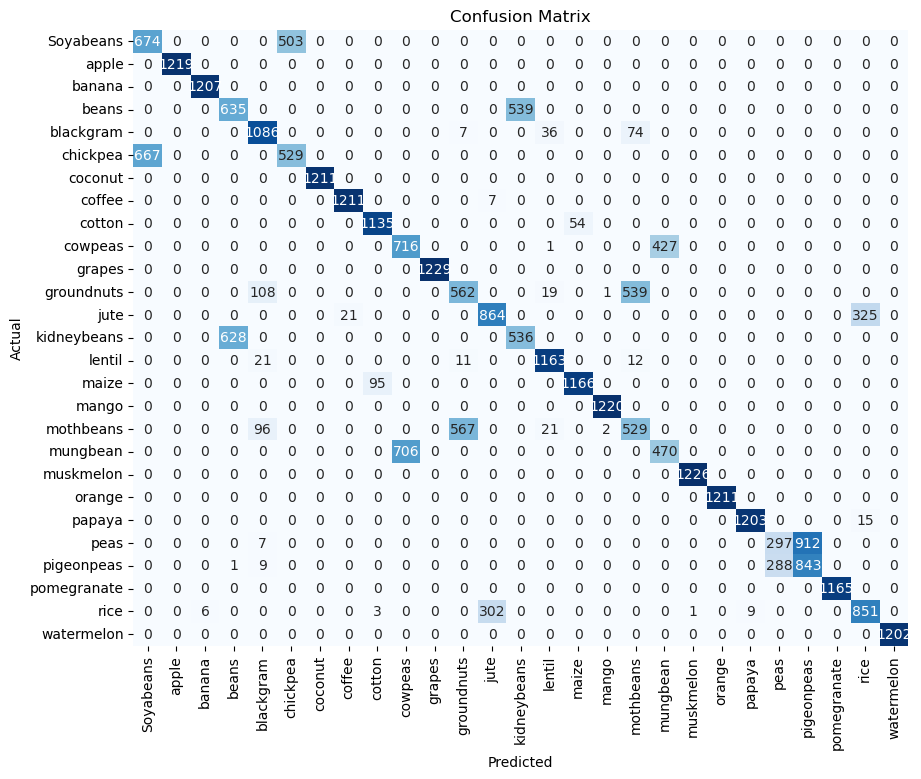

              precision    recall  f1-score   support

   Soyabeans       0.50      0.57      0.54      1177
       apple       1.00      1.00      1.00      1219
      banana       1.00      1.00      1.00      1207
       beans       0.50      0.54      0.52      1174
   blackgram       0.82      0.90      0.86      1203
    chickpea       0.51      0.44      0.47      1196
     coconut       1.00      1.00      1.00      1211
      coffee       0.98      0.99      0.99      1218
      cotton       0.92      0.95      0.94      1189
     cowpeas       0.50      0.63      0.56      1144
      grapes       1.00      1.00      1.00      1229
  groundnuts       0.49      0.46      0.47      1229
        jute       0.74      0.71      0.73      1210
 kidneybeans       0.50      0.46      0.48      1164
      lentil       0.94      0.96      0.95      1207
       maize       0.96      0.92      0.94      1261
       mango       1.00      1.00      1.00      1220
   mothbeans       0.46    

In [ ]:
evaluate(logistic_regression)

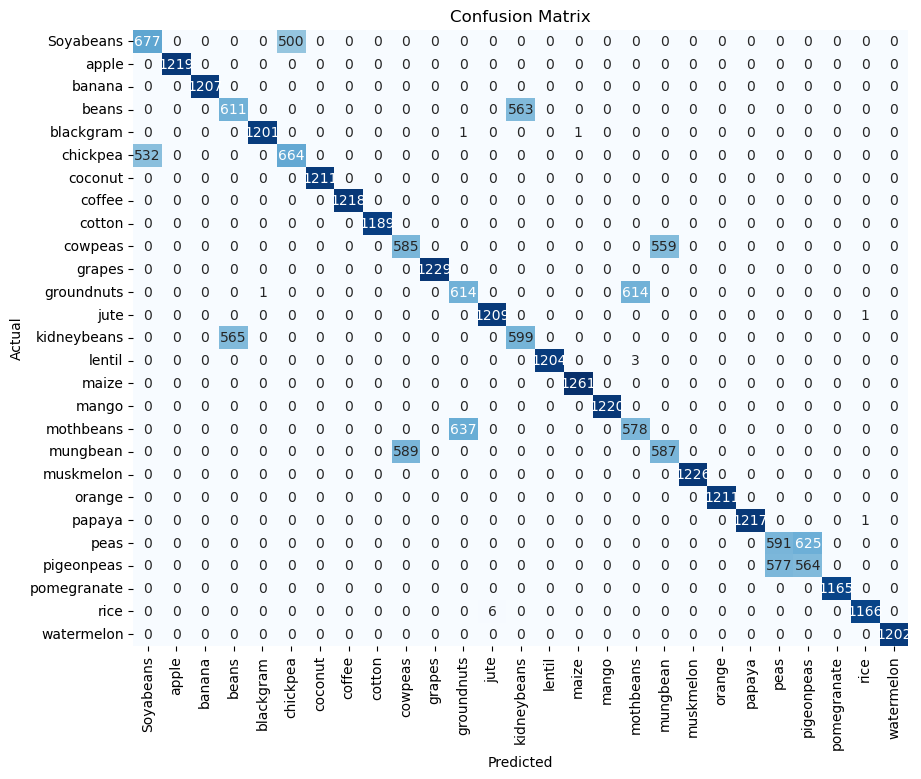

              precision    recall  f1-score   support

   Soyabeans       0.56      0.58      0.57      1177
       apple       1.00      1.00      1.00      1219
      banana       1.00      1.00      1.00      1207
       beans       0.52      0.52      0.52      1174
   blackgram       1.00      1.00      1.00      1203
    chickpea       0.57      0.56      0.56      1196
     coconut       1.00      1.00      1.00      1211
      coffee       1.00      1.00      1.00      1218
      cotton       1.00      1.00      1.00      1189
     cowpeas       0.50      0.51      0.50      1144
      grapes       1.00      1.00      1.00      1229
  groundnuts       0.49      0.50      0.49      1229
        jute       1.00      1.00      1.00      1210
 kidneybeans       0.52      0.51      0.52      1164
      lentil       1.00      1.00      1.00      1207
       maize       1.00      1.00      1.00      1261
       mango       1.00      1.00      1.00      1220
   mothbeans       0.48    

In [ ]:
evaluate(decision_tree)

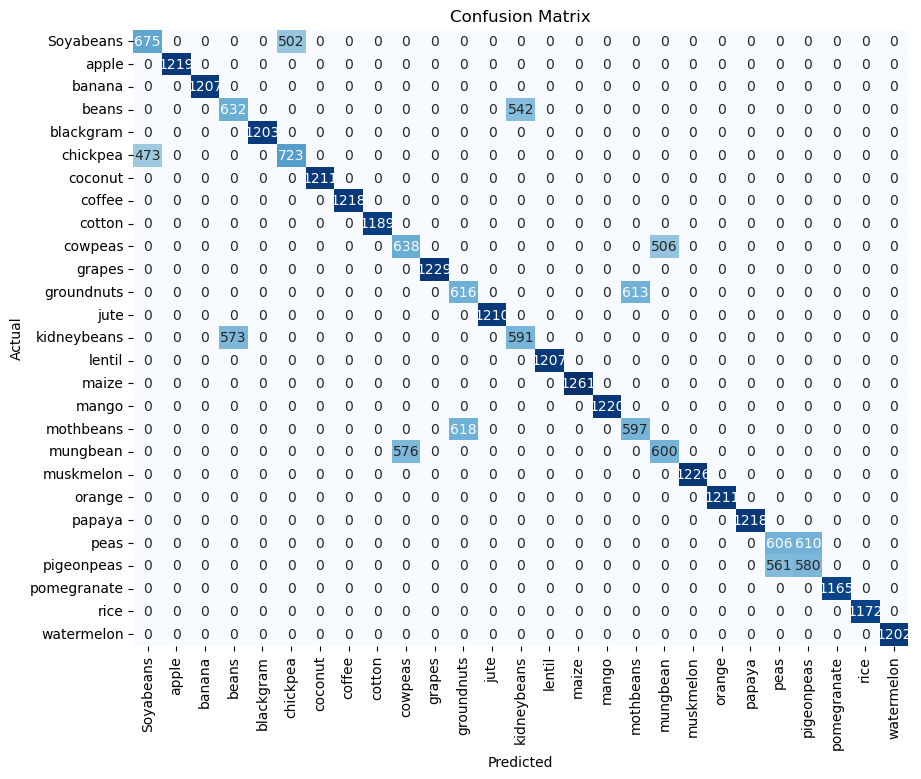

              precision    recall  f1-score   support

   Soyabeans       0.59      0.57      0.58      1177
       apple       1.00      1.00      1.00      1219
      banana       1.00      1.00      1.00      1207
       beans       0.52      0.54      0.53      1174
   blackgram       1.00      1.00      1.00      1203
    chickpea       0.59      0.60      0.60      1196
     coconut       1.00      1.00      1.00      1211
      coffee       1.00      1.00      1.00      1218
      cotton       1.00      1.00      1.00      1189
     cowpeas       0.53      0.56      0.54      1144
      grapes       1.00      1.00      1.00      1229
  groundnuts       0.50      0.50      0.50      1229
        jute       1.00      1.00      1.00      1210
 kidneybeans       0.52      0.51      0.51      1164
      lentil       1.00      1.00      1.00      1207
       maize       1.00      1.00      1.00      1261
       mango       1.00      1.00      1.00      1220
   mothbeans       0.49    

In [ ]:
evaluate(random_forest)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000879 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1355
[LightGBM] [Info] Number of data points in the train set: 48600, number of used features: 7
[LightGBM] [Info] Start training from score -3.283140
[LightGBM] [Info] Start training from score -3.306449
[LightGBM] [Info] Start training from score -3.299733
[LightGBM] [Info] Start training from score -3.281496
[LightGBM] [Info] Start training from score -3.297505
[LightGBM] [Info] Start training from score -3.293617
[LightGBM] [Info] Start training from score -3.301967
[LightGBM] [Info] Start training from score -3.305887
[LightGBM] [Info] Start training from score -3.289744
[LightGBM] [Info] Start training from score -3.265200
[LightGBM] [Info] Start training from score -3.312079
[LightGBM] [Info] Start training from score -3.312079


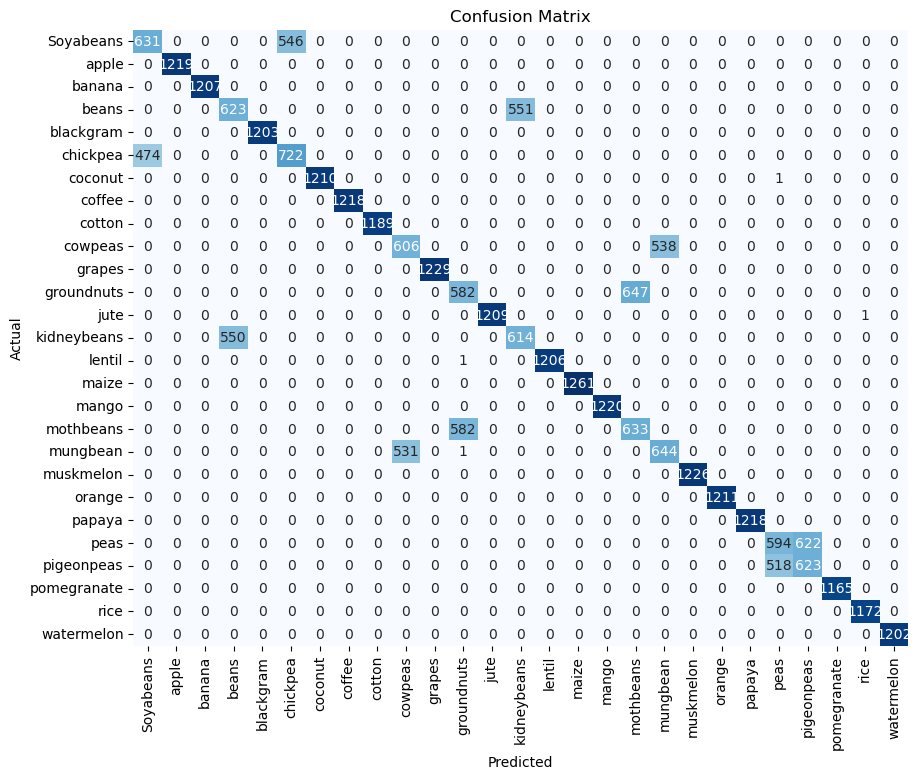

              precision    recall  f1-score   support

   Soyabeans       0.57      0.54      0.55      1177
       apple       1.00      1.00      1.00      1219
      banana       1.00      1.00      1.00      1207
       beans       0.53      0.53      0.53      1174
   blackgram       1.00      1.00      1.00      1203
    chickpea       0.57      0.60      0.59      1196
     coconut       1.00      1.00      1.00      1211
      coffee       1.00      1.00      1.00      1218
      cotton       1.00      1.00      1.00      1189
     cowpeas       0.53      0.53      0.53      1144
      grapes       1.00      1.00      1.00      1229
  groundnuts       0.50      0.47      0.49      1229
        jute       1.00      1.00      1.00      1210
 kidneybeans       0.53      0.53      0.53      1164
      lentil       1.00      1.00      1.00      1207
       maize       1.00      1.00      1.00      1261
       mango       1.00      1.00      1.00      1220
   mothbeans       0.49    

In [ ]:
import lightgbm as lgb
from sklearn.metrics import classification_report

# Prepare the dataset
lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

# Train the model
light_gbm = lgb.LGBMClassifier()
light_gbm.fit(X_train, y_train)

# THEN evaluate
evaluate(light_gbm)


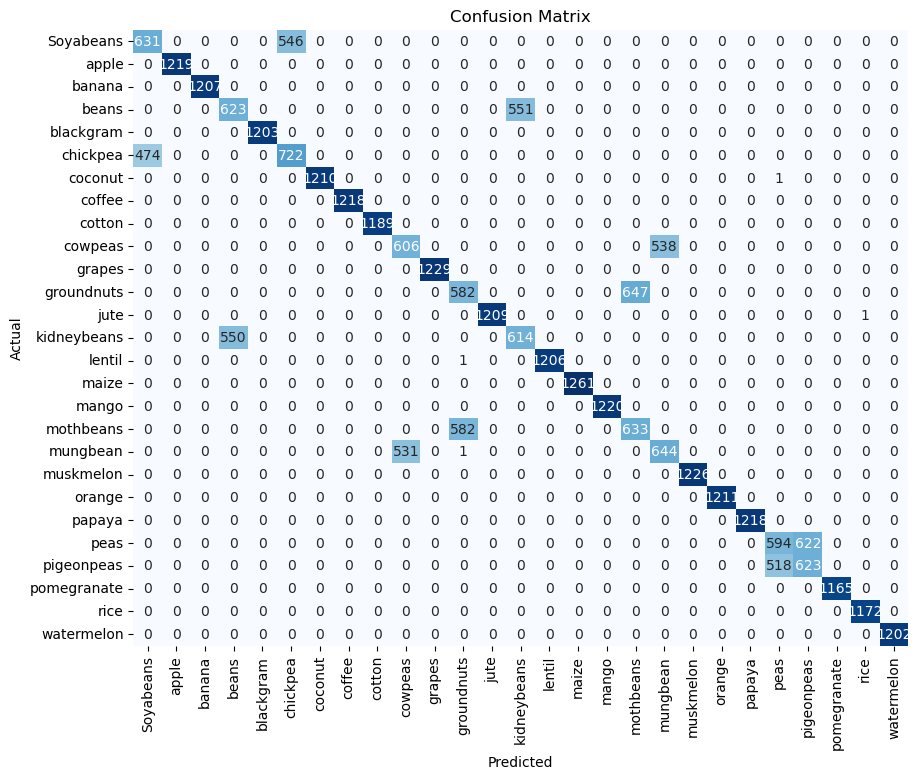

              precision    recall  f1-score   support

   Soyabeans       0.57      0.54      0.55      1177
       apple       1.00      1.00      1.00      1219
      banana       1.00      1.00      1.00      1207
       beans       0.53      0.53      0.53      1174
   blackgram       1.00      1.00      1.00      1203
    chickpea       0.57      0.60      0.59      1196
     coconut       1.00      1.00      1.00      1211
      coffee       1.00      1.00      1.00      1218
      cotton       1.00      1.00      1.00      1189
     cowpeas       0.53      0.53      0.53      1144
      grapes       1.00      1.00      1.00      1229
  groundnuts       0.50      0.47      0.49      1229
        jute       1.00      1.00      1.00      1210
 kidneybeans       0.53      0.53      0.53      1164
      lentil       1.00      1.00      1.00      1207
       maize       1.00      1.00      1.00      1261
       mango       1.00      1.00      1.00      1220
   mothbeans       0.49    

In [ ]:
evaluate(light_gbm)

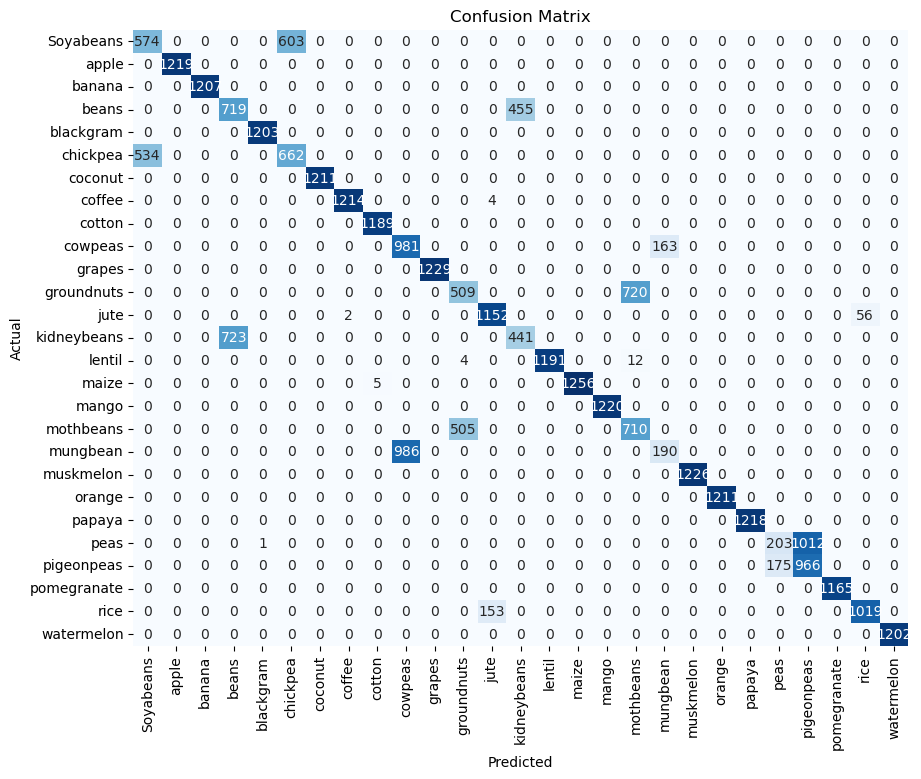

              precision    recall  f1-score   support

   Soyabeans       0.52      0.49      0.50      1177
       apple       1.00      1.00      1.00      1219
      banana       1.00      1.00      1.00      1207
       beans       0.50      0.61      0.55      1174
   blackgram       1.00      1.00      1.00      1203
    chickpea       0.52      0.55      0.54      1196
     coconut       1.00      1.00      1.00      1211
      coffee       1.00      1.00      1.00      1218
      cotton       1.00      1.00      1.00      1189
     cowpeas       0.50      0.86      0.63      1144
      grapes       1.00      1.00      1.00      1229
  groundnuts       0.50      0.41      0.45      1229
        jute       0.88      0.95      0.91      1210
 kidneybeans       0.49      0.38      0.43      1164
      lentil       1.00      0.99      0.99      1207
       maize       1.00      1.00      1.00      1261
       mango       1.00      1.00      1.00      1220
   mothbeans       0.49    

In [ ]:
svc.fit(X_train, y_train)   # Train the model first
evaluate(svc)               # Then evaluate

In [ ]:
%%capture
# List of classifiers
classifiers = [
    logistic_regression,
    decision_tree,
    random_forest,
    light_gbm,
    svc
]

# Initialize an empty list to store DataFrames
dfs = []

# Loop through classifiers
for classifier in classifiers:
    # Calculate metrics for the current classifier
    metrics_result = evaluate(classifier, return_=True, conf_matrix=False)

    # Create a DataFrame from the dictionary
    metrics_df = pd.DataFrame([metrics_result])

    # Append the DataFrame to the list
    dfs.append(metrics_df)

# Concatenate DataFrames into a single DataFrame
results_df = pd.concat(dfs, ignore_index=True)

# Format the metrics to 4 decimal places in the DataFrame
results_df["accuracy"] = results_df["accuracy"].map("{:.4f}".format)
results_df["precision"] = results_df["precision"].map("{:.4f}".format)
results_df["recall"] = results_df["recall"].map("{:.4f}".format)
results_df["f1"] = results_df["f1"].map("{:.4f}".format)

In [ ]:
results_df

Model accuracy precision  recall      f1
0      LogisticRegression   0.7827    0.7816  0.7827  0.7785
1  DecisionTreeClassifier   0.8218    0.8219  0.8218  0.8218
2  RandomForestClassifier   0.8280    0.8280  0.8280  0.8279
3          LGBMClassifier   0.8283    0.8285  0.8283  0.8282
4                     SVC   0.8113    0.8140  0.8113  0.8011

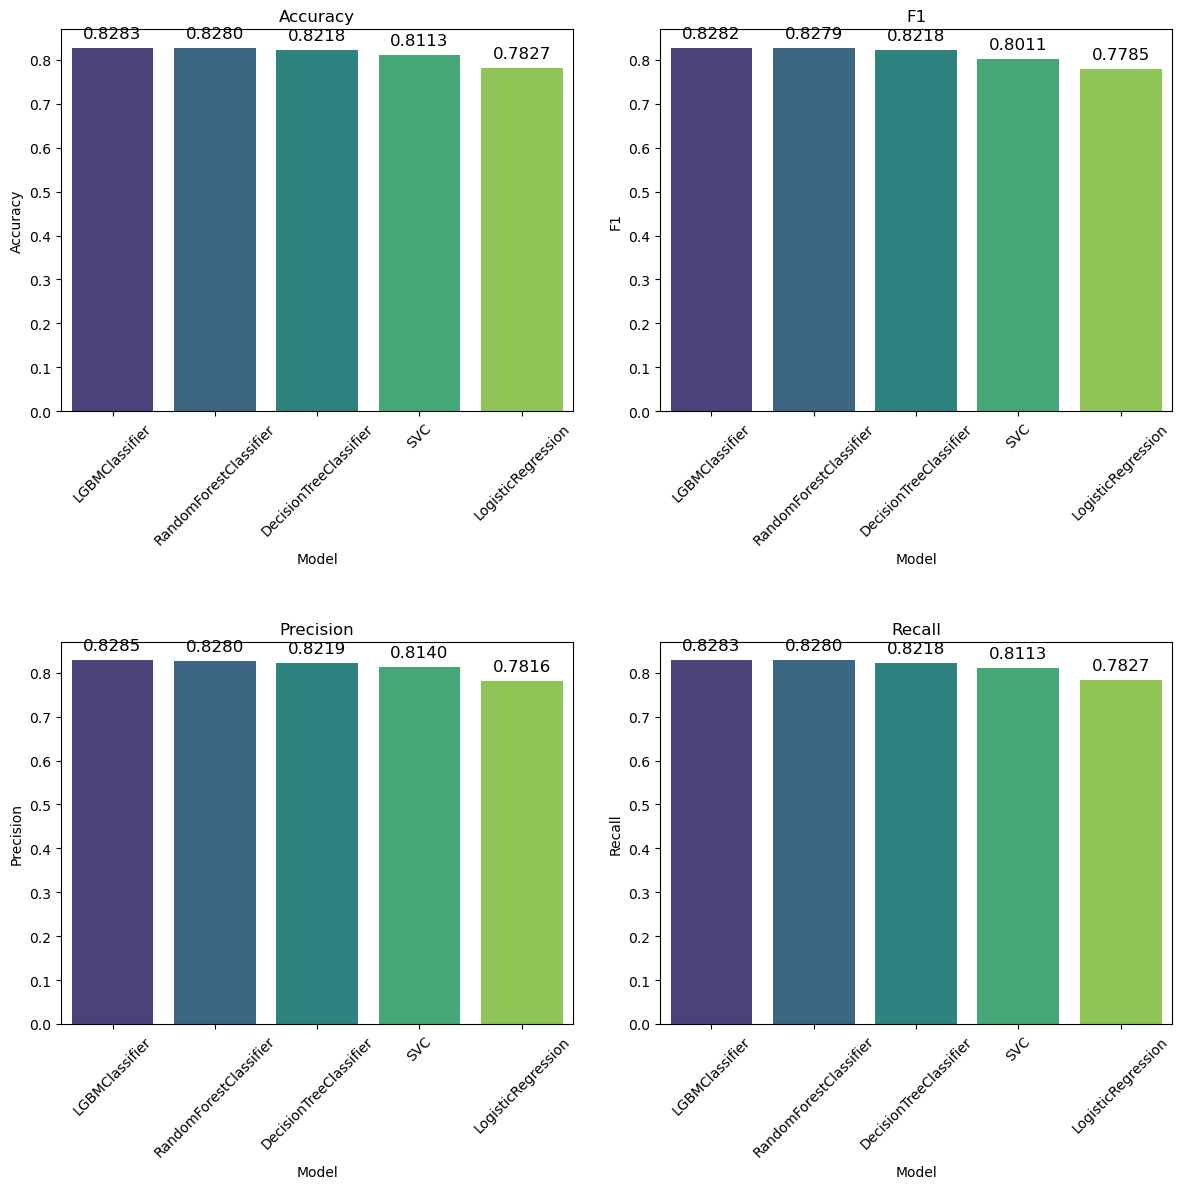

In [ ]:

results_df["accuracy"] = results_df["accuracy"].astype(float)
results_df["precision"] = results_df["precision"].astype(float)
results_df["recall"] = results_df["recall"].astype(float)
results_df["f1"] = results_df["f1"].astype(float)

# Define the metrics to plot
metrics_to_plot = [
    "accuracy",
    "f1",
    "precision",
    "recall",
]

# Plotting
plt.figure(figsize=(12, 12))  # Adjust figure size for vertical layout

# Loop through each metric and create a subplot
for i, metric in enumerate(metrics_to_plot, 1):
    # Sort the DataFrame for the current metric
    sorted_df = results_df.sort_values(by=metric, ascending=False)

    plt.subplot(2, 2, i)
    ax = sns.barplot(x="Model", y=metric, data=sorted_df, palette="viridis")  # Swap x and y

    # Add the metric values on top of the bars
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.4f}',  # Use height instead of width
                    (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha='center', va='bottom',  # Adjust alignment for vertical bars
                    xytext=(0, 5), textcoords='offset points', fontsize=12)
    plt.xticks(rotation=45)

    plt.title(metric.capitalize())
    plt.xlabel("Model")
    plt.ylabel(metric.capitalize())

# Adjust the layout for better visualization
plt.tight_layout(w_pad=2, h_pad=4)
plt.show()

In [ ]:
print(df.drop('label', axis=1).columns.tolist())


['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'source']


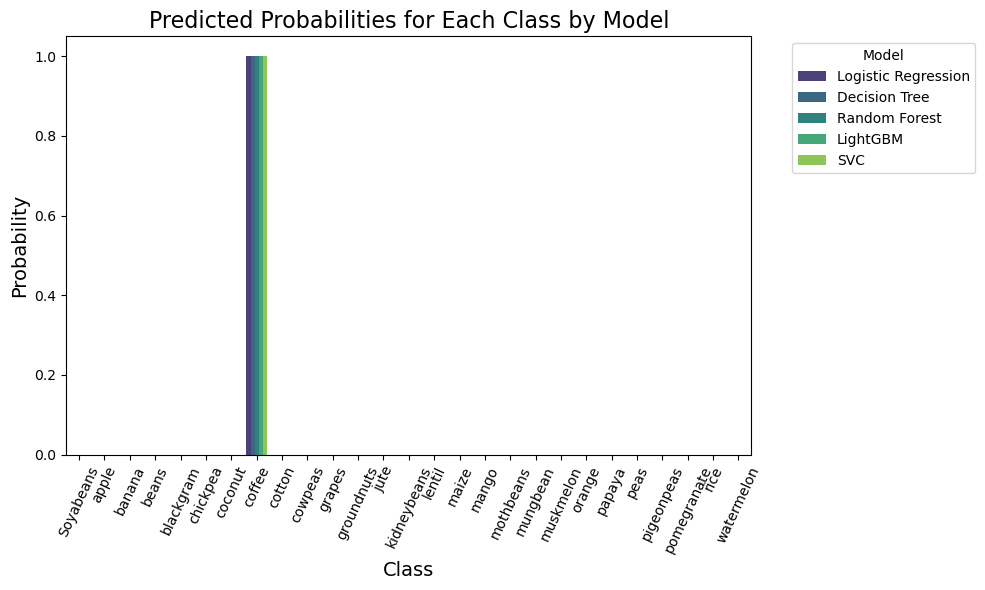


✅ Recommended crop is: coffee


In [ ]:
# Corrected input: 7 numerical features, no 'source'
features = [99, 15, 27, 27.42, 56.64, 6.09, 140.5]

# Predict probabilities for each class
lr_probs = logistic_regression.predict_proba([features])[0]
dt_probs = decision_tree.predict_proba([features])[0]
rf_probs = random_forest.predict_proba([features])[0]
lgbm_probs = light_gbm.predict_proba([features])[0]
svc_probs = svc.predict_proba([features])[0]

# Create a DataFrame to store the probabilities
probs_df = pd.DataFrame({
    'Class': class_names,
    'Logistic Regression': lr_probs,
    'Decision Tree': dt_probs,
    'Random Forest': rf_probs,
    'LightGBM': lgbm_probs,
    'SVC': svc_probs
})

# Melt the DataFrame for Seaborn
probs_df_melted = probs_df.melt(id_vars='Class', var_name='Model', value_name='Probability')

# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Class', y='Probability', hue='Model', data=probs_df_melted, palette='viridis')
plt.title('Predicted Probabilities for Each Class by Model', fontsize=16)
plt.xlabel('Class', fontsize=14)
plt.ylabel('Probability', fontsize=14)
plt.xticks(rotation=65)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Best model recommendation (using Random Forest)
predicted_class = class_names[np.argmax(rf_probs)]
print(f"\n✅ Recommended crop is: {predicted_class}")


In [ ]:
import pickle
with open('model.pkl', 'wb') as f:
    pickle.dump(random_forest, f)

In [ ]:
# Count number of samples per crop
crop_counts = df['label'].value_counts()

# Display
print("📊 Number of samples per crop:\n")
print(crop_counts)

📊 Number of samples per crop:

label
Soyabeans      3000
papaya         3000
cotton         3000
orange         3000
apple          3000
watermelon     3000
grapes         3000
mango          3000
banana         3000
maize          3000
rice           3000
jute           3000
coconut        3000
muskmelon      3000
beans          3000
pomegranate    3000
lentil         3000
blackgram      3000
mungbean       3000
mothbeans      3000
pigeonpeas     3000
kidneybeans    3000
chickpea       3000
cowpeas        3000
groundnuts     3000
peas           3000
coffee         3000
Name: count, dtype: int64


In [ ]:
models = {
    "Logistic Regression": logistic_regression,
    "Decision Tree": decision_tree,
    "Random Forest": random_forest,
    "LightGBM": light_gbm,
    "SVC": svc
}

for name, model in models.items():
    print(f"\n🔍 {name}")

    start_train = time.time()
    model.fit(X_train, y_train)
    end_train = time.time()

    start_val = time.time()
    y_pred = model.predict(X_test)
    end_val = time.time()

    print(f"⏱️ Training Time: {end_train - start_train:.2f} seconds")
    print(f"⏱️ Validation Time: {end_val - start_val:.2f} seconds")




🔍 Logistic Regression
⏱️ Training Time: 11.67 seconds
⏱️ Validation Time: 0.01 seconds

🔍 Decision Tree
⏱️ Training Time: 0.48 seconds
⏱️ Validation Time: 0.01 seconds

🔍 Random Forest
⏱️ Training Time: 9.01 seconds
⏱️ Validation Time: 0.71 seconds

🔍 LightGBM
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1355
[LightGBM] [Info] Number of data points in the train set: 48600, number of used features: 7
[LightGBM] [Info] Start training from score -3.283140
[LightGBM] [Info] Start training from score -3.306449
[LightGBM] [Info] Start training from score -3.299733
[LightGBM] [Info] Start training from score -3.281496
[LightGBM] [Info] Start training from score -3.297505
[LightGBM] [Info] Start training from score -3.293617
[LightGBM] [Info] Start training from score -3.301967
[LightGB

In [ ]:
import psutil

def get_resource_usage():
    process = psutil.Process()
    mem = process.memory_info().rss / (1024 * 1024)  # in MB
    cpu = process.cpu_percent(interval=0.1)          # short interval
    return mem, cpu

for name, model in models.items():
    print(f"\n🔍 {name}")
    try:
        mem_before, cpu_before = get_resource_usage()
        start_train = time.time()
        model.fit(X_train, y_train)
        end_train = time.time()
        mem_after, cpu_after = get_resource_usage()

        start_val = time.time()
        y_pred = model.predict(X_test)
        end_val = time.time()

        print(f"⏱️ Training Time: {end_train - start_train:.2f} seconds")
        print(f"⏱️ Validation Time: {end_val - start_val:.2f} seconds")
        print(f"📊 Memory Usage: {mem_after - mem_before:.2f} MB")
        print(f"⚙️ CPU Usage: {cpu_after:.2f}%")

    except Exception as e:
        print(f"❌ Error with {name}: {e}")



🔍 Logistic Regression
⏱️ Training Time: 10.82 seconds
⏱️ Validation Time: 0.01 seconds
📊 Memory Usage: 5.35 MB
⚙️ CPU Usage: 0.00%

🔍 Decision Tree
⏱️ Training Time: 0.44 seconds
⏱️ Validation Time: 0.01 seconds
📊 Memory Usage: 2.40 MB
⚙️ CPU Usage: 0.00%

🔍 Random Forest
⏱️ Training Time: 8.99 seconds
⏱️ Validation Time: 0.74 seconds
📊 Memory Usage: 0.77 MB
⚙️ CPU Usage: 0.00%

🔍 LightGBM
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000962 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1355
[LightGBM] [Info] Number of data points in the train set: 48600, number of used features: 7
[LightGBM] [Info] Start training from score -3.283140
[LightGBM] [Info] Start training from score -3.306449
[LightGBM] [Info] Start training from score -3.299733
[LightGBM] [Info] Start training from score -3.281496
[LightGBM] [Info] Start training from score -3.297505
[LightGBM] [Info] Start training from score -3.2